In [84]:
"""
This project leverages advanced machine learning techniques and natural language processing (NLP) to analyze 
Airbnb listings and customer reviews data. The goal is to extract meaningful insights from textual reviews 
and structured listing data to better understand customer experiences and preferences. By employing libraries 
such as TensorFlow, scikit-learn, NLTK, and matplotlib in a Python environment, this analysis not only highlights 
key factors influencing guest satisfaction but also predicts trends that could assist hosts in optimizing their offerings. 
The results from this project are intended to aid both new and existing Airbnb hosts in enhancing guest experiences 
and improving the overall service quality.
"""
from datetime import datetime
from collections import Counter
import pymongo
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
nltk.download('all')
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN
%matplotlib inline
#----------------------------------------------------------------------
# Set Visuals and Fonts for Plots
#----------------------------------------------------------------------

# Define a consistent color palette
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Set the color cycle for Matplotlib
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

# Tell Seaborn to use the same color cycle
sns.set_palette(colors)


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/sanjayv/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/sanjayv/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/sanjayv/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/sanjayv/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/sanjayv/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading pa

In [85]:
def convert_to_integer(value):
    """
    Convert integer fields .
    :param record: This is dataframe record. 
    """
    if isinstance(value, dict) and '$numberInt' in value:
        return int(value['$numberInt'])
    if isinstance(value, (int, float)) and not np.isnan(value):
        return int(value)
    return None

def convert_to_float(value):
    """
    Convert decimal fields 
    :param record: This is dataframe record. 
    """
    if isinstance(value, dict) and '$numberDecimal' in value:
        return float(value['$numberDecimal'])
    if isinstance(value, (int, float)) and not np.isnan(value):
        return float(value)
    return None

def convert_numeric_fields(record):
    """
    Convert date fields from various formats to a unified format.
    :param record: This is dataframe record.
    """
    numeric_int_fields = ['accommodates', 'bedrooms', 'beds', 'number_of_reviews', 'guests_included']
    for field in numeric_int_fields:
        record[field] = convert_to_integer(record.get(field))

    numeric_decimal_fields = ['bathrooms', 'price', 'security_deposit', 'cleaning_fee', 'extra_people']
    for field in numeric_decimal_fields:
        record[field] = convert_to_float(record.get(field))



In [86]:
def convert_date_fields(record):
     """
     Convert date fields from various formats to a unified format.
     :param record: This is dataframe record.
     """
     date_fields = ['last_scraped', 'calendar_last_scraped', 'first_review', 'last_review']
     for field in date_fields:
        if field in record and isinstance(record[field], dict) and '$date' in record[field] and '$numberLong' in record[field]['$date']:
            timestamp_ms = int(record[field]['$date']['$numberLong'])
            record[field] = datetime.utcfromtimestamp(timestamp_ms / 1000.0)

In [87]:
#----------------------------------------------------------------------
# Set Font Properties Function
#----------------------------------------------------------------------
def set_font_properties(paragraph, font_size=Pt(18), font_name='Arial'):
    for run in paragraph.runs:
        run.font.size = font_size
        run.font.name = font_name

In [88]:
def transform_record(record):
    """
    The data attributes are pre proprocessed,cleaned and flattened before analysis.
    :param record: This is dataframe record. 
    Operations:
        - Converts numeric fields from string representations to integers or floats.
        - Flattens 'amenities' into a comma-separated string.
        - Simplifies 'address' into a single string combining street, market, and country.
        - Converts 'availability' fields from nested dictionaries into flat integer fields.
        - Flattens 'review_scores' and removes the original nested dictionary.
        - Calls 'convert_date_fields' to handle date conversions.
        
    Returns:
        dict: The modified record with cleaned and flattened data.

    Raises:
        ValueError: If conversion functions encounter an invalid format that they cannot process.
        KeyError: If expected keys are missing in the nested dictionaries.
     Note:
        This function is part of a larger data preprocessing module and relies on several helper
        functions such as 'convert_numeric_fields' and 'convert_date_fields' to perform specific
        tasks. Ensure these helper functions are defined and properly handle the data types and
        structures expected from 'record'.
    """
    # Convert numeric fields contained in strings to the appropriate numeric type
    convert_numeric_fields(record)

    # Flatten amenities into a comma-separated string (or handle differently as needed)
    if 'amenities' in record:
        record['amenities'] = ', '.join(record['amenities'])
    # Example of simplifying the address field - customize this as needed
    if 'address' in record:
        address = record['address']
        street = address.get('street', '')
        market = address.get('market', '')
        country = address.get('country', '')
        record['simple_address'] = f"{street}, {market}, {country}"
       # record['simple_address'] = f"{address.get('street', '')}, {address.get('market', '')}, {address.get('country', '')}"
    availability_fields = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
    for field in availability_fields:
        if 'availability' in record and field in record['availability']:
            # Extract and convert the integer value
            record[f'availability_{field}'] = int(record['availability'][field]['$numberInt'])
        
    # Remove the original 'availability' dictionary to avoid redundancy
    if 'availability' in record:
        del record['availability']
    # Flatten 'review_scores' fields
    review_score_fields = [
        'review_scores_accuracy', 'review_scores_cleanliness',
        'review_scores_checkin', 'review_scores_communication',
        'review_scores_location', 'review_scores_value',
        'review_scores_rating'
    ]
    for field in review_score_fields:
        if 'review_scores' in record and field in record['review_scores']:
            # Extract and convert the integer value
            record[field] = int(record['review_scores'][field]['$numberInt'])
    # Remove the original 'review_scores' dictionary to avoid redundancy
    if 'review_scores' in record:
        del record['review_scores']
    # Optionally, handle 'reviews' and other nested objects/arrays as needed
    # Process host-specific fields if they exist
    
    if 'host' in record:
        host_fields = ['host_listings_count', 'host_total_listings_count']
        other_host_fields = ['host_id', 'host_location', 'host_is_superhost', 'host_verifications',
                             'host_response_time', 'host_thumbnail_url', 'host_picture_url',
                             'host_has_profile_pic', 'host_response_rate', 'host_identity_verified']
        all_host_fields = host_fields + other_host_fields

        for field in all_host_fields:
            if field in record['host']:
                value = record['host'][field]
                if isinstance(value, dict) and '$numberInt' in value:
                    record[field] = int(value['$numberInt'])
                else:
                    record[field] = value

        if 'host_verifications' in record.get('host', {}):
            record['verification_count'] = len(record['host']['host_verifications'])
        # Handle 'host_response_time' if it's NaN or not provided
        if 'host_response_time' not in record or pd.isna(record['host_response_time']):
            record['host_response_time'] = 'No response'  # Set to 'No response' if not provided or NaN
        # Correctly handle host_response_rate as string or already processed number
        response_rate = record.get('host_response_rate')
        if isinstance(response_rate, str):
            if response_rate.strip() == '':
                record['host_response_rate'] = 0
            else:
                record['host_response_rate'] = float(response_rate.strip('%')) / 100
        elif isinstance(response_rate, (int, float)):
            record['host_response_rate'] = response_rate / 100
        else:
            record['host_response_rate'] = 0  # Default to 0 if None or unrecognized type

    
    convert_date_fields(record)
    return record


In [89]:
def add_new_slide_with_title(presentation, title_text):
    """
    Helper function to add a new slide with a title to a PowerPoint presentation.
    :param presentation: The Presentation object to add the slide to.
    :param title_text: The text for the slide's title.
    :return: The newly created slide object.
    """
    # Assume the blank layout is at index 6; this may need adjustment
    blank_slide_layout = presentation.slide_layouts[6]
    local_slide = presentation.slides.add_slide(blank_slide_layout)

    # Define the title text and position
    title_left = Inches(0)
    title_top = Inches(0.1)
    title_width = Inches(10)
    title_height = Inches(0.5)
    # Add a text box shape for the title
    title_shape = local_slide.shapes.add_textbox(title_left, title_top, title_width, title_height)
    title_frame = title_shape.text_frame
    title_frame.text = title_text

    # Set font size and alignment for the title
    for paragraph in title_frame.paragraphs:
        paragraph.alignment = PP_ALIGN.CENTER  # Center alignment
        for run in paragraph.runs:
            run.font.size = Pt(32)  # Define font size
        if len(paragraph.runs) == 0:  # Create a run if there isn't one
            run = paragraph.add_run()
            run.font.size = Pt(32)

    return local_slide


In [90]:

def add_slide_with_title_and_image(presentation, title_text, image_path):
    """
    Add a new slide with a title and an image to a PowerPoint presentation. This function first
    creates a slide with a title and then adds an image below the title.

    Parameters:
        presentation (Presentation): The Presentation object to which the slide is to be added.
        title_text (str): The text for the slide's title. This will be displayed at the top of the slide.
        image_path (str): The file path of the image to add to the slide. This path must be accessible
                          from the current working directory and point to a valid image file.

    Raises:
        FileNotFoundError: If the image_path does not point to a valid file.
        Exception: General exceptions related to adding slides or images, providing a message with more details.

    Example:
        >>> from pptx import Presentation
        >>> prs = Presentation()
        >>> add_slide_with_title_and_image(prs, "Sample Title", "/path/to/image.png")
        >>> prs.save('presentation.pptx')
        
    Note:
        - Ensure that 'image_path' is a valid path to an image file and accessible.
        - This function relies on 'add_new_slide_with_title' to add a slide with the specified title before
          adding the image. If 'add_new_slide_with_title' is modified, it may affect this function's behavior.
    """
    try:
        local_slide = add_new_slide_with_title(presentation, title_text)

        # Define the position and size for the image
        image_left = Inches(0.5)
        image_top = Inches(0.7)
        desired_width = Inches(8.5)
        desired_height = Inches(6.6)

        # Add the image to the slide
        local_slide.shapes.add_picture(image_path, image_left, image_top, width=desired_width, height=desired_height)
    except FileNotFoundError:
        raise FileNotFoundError(f"The specified image file was not found: {image_path}")
    except Exception as e:
        raise Exception(f"An error occurred while adding the slide or image: {str(e)}")

In [91]:
def save_ppt(prs):
    """
        Save the powerpoint presentation.
    :param presentation: The reference to the presentation object.
    """
    try:
        prs.save('EDA6.pptx')
        print("Presentation saved successfully.")
    except PermissionError:
        print("Failed to save the presentation. The file may be open in another application.")
    except IOError as e:
        print(f"Error saving presentation: {e}")

In [92]:
def add_slide_with_title_and_two_columns(presentation, title, content):
    """
        Save the powerpoint presentation.
    :param presentation: The reference to the presentation object.
    :param title: The title of the slide.
    :param content:The text content that is result of analysis.
    """
    local_slide = add_new_slide_with_title(presentation, title)

    # Split content into two columns
    content_lines = content.split('\n')
    mid_point = len(content_lines) // 2
    content_left = '\n'.join(content_lines[:mid_point])
    content_right = '\n'.join(content_lines[mid_point:])

    # Column 1
    textbox_left = local_slide.shapes.add_textbox(Inches(0.5), Inches(1.5), Inches(4.5), Inches(5))
    text_frame_left = textbox_left.text_frame
    text_frame_left.text = content_left

    # Column 2
    textbox_right = local_slide.shapes.add_textbox(Inches(5.5), Inches(1.5), Inches(4.5), Inches(5))
    text_frame_right = textbox_right.text_frame
    text_frame_right.text = content_right


In [93]:
def add_blank_slide_with_text(presentation, text):
    """
        Add a blank slide to the presentation and the provide text 
    :param presentation: The reference to the presentation object.
    :param text: The text to be added to the slide.
    """
    # Use the blank slide layout (usually at index 6)
    blank_slide_layout = presentation.slide_layouts[6]
    local_slide = presentation.slides.add_slide(blank_slide_layout)

    # Define the position and size of the textbox
    left = Inches(1)
    top = Inches(1)
    width = Inches(8)
    height = Inches(5.5)
    # Add a textbox and set its text
    textbox = local_slide.shapes.add_textbox(left, top, width, height)
    text_frame = textbox.text_frame
    text_frame.text = text  # Set the captured text as the content

In [94]:

# Connect to MongoDB
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["mydatabase"]
collection = db["listingAndReviews"]

documents = list(collection.find({}))

# Create DataFrame
df = pd.DataFrame(documents)

# Transform your data

df_clean = df.apply(lambda x: transform_record(x.to_dict()), axis=1)
df_clean = pd.DataFrame(list(df_clean))

prs = Presentation()

# Add a title slide
slide_layout = prs.slide_layouts[0]  # 0 is the index for a title slide
slide = prs.slides.add_slide(slide_layout)

title = slide.shapes.title
subtitle = slide.placeholders[1]

title.text = "Exploring Airbnb Dataset"
subtitle.text = "Exploratory Data Analysis with Python"
print(df_clean.columns)
print(df_clean.head())

Index(['_id', 'listing_url', 'name', 'summary', 'space', 'description',
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',
       'house_rules', 'property_type', 'room_type', 'bed_type',
       'minimum_nights', 'maximum_nights', 'cancellation_policy',
       'last_scraped', 'calendar_last_scraped', 'first_review', 'last_review',
       'accommodates', 'bedrooms', 'beds', 'number_of_reviews', 'bathrooms',
       'amenities', 'price', 'security_deposit', 'cleaning_fee',
       'extra_people', 'guests_included', 'images', 'host', 'address',
       'reviews', 'weekly_price', 'monthly_price', 'reviews_per_month',
       'simple_address', 'availability_availability_30',
       'availability_availability_60', 'availability_availability_90',
       'availability_availability_365', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'review_

In [95]:
nan_columns = df_clean.isnull().any()
print(nan_columns[nan_columns].index.tolist())


['first_review', 'last_review', 'bedrooms', 'beds', 'bathrooms', 'security_deposit', 'cleaning_fee', 'guests_included', 'weekly_price', 'monthly_price', 'reviews_per_month', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'review_scores_rating']


In [96]:
# Select numeric columns only
numeric_cols = df_clean.select_dtypes(include=['number'])

# Check for any infinite values in numeric columns
inf_columns_numeric = np.isinf(numeric_cols).any()

# Print columns with infinite values (from the subset of numeric columns)
#print(inf_columns_numeric[inf_columns_numeric == True].index.tolist())
print(inf_columns_numeric[inf_columns_numeric].index.tolist())



[]


In [97]:
num_rows_with_nan = df_clean.isnull().any(axis=1).sum()
print(f"Number of rows with at least one NaN value: {num_rows_with_nan}")

Number of rows with at least one NaN value: 5555


In [98]:
# Select numeric columns
numeric_cols = df_clean.select_dtypes(include=['number'])

# Count NaN values for each numeric column
nan_counts = numeric_cols.isnull().sum()

# Print the count of NaN values for each numeric column
print(nan_counts)

zero_counts = (numeric_cols == 0).sum()
print("Count of Zero Values")
# Print the count of zero values for each numeric column
print(zero_counts)

accommodates                        0
bedrooms                            5
beds                               13
number_of_reviews                   0
bathrooms                          10
price                               0
security_deposit                 2084
cleaning_fee                     1531
extra_people                        0
availability_availability_30        0
availability_availability_60        0
availability_availability_90        0
availability_availability_365       0
review_scores_accuracy           1476
review_scores_cleanliness        1473
review_scores_checkin            1475
review_scores_communication      1474
review_scores_location           1474
review_scores_value              1475
review_scores_rating             1474
host_listings_count                 0
host_total_listings_count           0
host_response_rate                  0
verification_count                  0
dtype: int64
Count of Zero Values
accommodates                        0
bedrooms        

In [99]:
print(df_clean.describe())

                        last_scraped          calendar_last_scraped  \
count                           5555                           5555   
mean   2019-03-01 12:48:43.420342016  2019-03-01 12:48:43.420342016   
min              2019-02-11 05:00:00            2019-02-11 05:00:00   
25%              2019-02-18 05:00:00            2019-02-18 05:00:00   
50%              2019-03-07 05:00:00            2019-03-07 05:00:00   
75%              2019-03-08 05:00:00            2019-03-08 05:00:00   
max              2019-03-11 04:00:00            2019-03-11 04:00:00   
std                              NaN                            NaN   

                        first_review                    last_review  \
count                           4167                           4167   
mean   2016-11-27 16:08:28.855291648  2018-08-15 20:18:09.416846848   
min              2009-10-27 04:00:00            2012-01-06 05:00:00   
25%              2015-12-08 17:00:00            2018-08-08 04:00:00   
50%  

In [100]:
# This code segment and the ones that follow are designed to clean, analyze and visualize data related to rental listings 
# in a DataFrame called df_clean.

# Impute NaN values

df_clean.loc[:, 'bedrooms'] = df_clean['bedrooms'].fillna(df_clean['bedrooms'].mode()[0])
df_clean.loc[:, 'beds'] = df_clean['beds'].fillna(df_clean['beds'].mode()[0])
df_clean.loc[:, 'bathrooms'] = df_clean['bathrooms'].fillna(df_clean['bathrooms'].median())

df_clean.loc[:, 'security_deposit'] = df_clean['security_deposit'].fillna(0)
df_clean.loc[:, 'cleaning_fee'] = df_clean['cleaning_fee'].fillna(0)

# For handling zeros (based on your previous example, adjusting bedrooms for studios)
df_clean.loc[df_clean['bedrooms'] == 0, 'bedrooms'] = 1
df_clean['_id'] = df_clean['_id'].astype(str)

# Filter out the record with _id '20275354'
df_clean = df_clean.loc[df_clean['_id'] != '20275354']
print(df_clean['host_total_listings_count'].describe())

count    5554.000000
mean       14.408174
std        65.854551
min         0.000000
25%         1.000000
50%         2.000000
75%         6.000000
max      1198.000000
Name: host_total_listings_count, dtype: float64


In [101]:
# Average Price by Property Type

avg_price_property_type = df_clean.groupby('property_type')['price'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.set_style('whitegrid')
sns.barplot(y=avg_price_property_type.index, x=avg_price_property_type.values, color='steelblue')
# plt.title('Average Price by Property Type', fontsize=14)
plt.xlabel('Average Price', fontsize=16)
plt.ylabel('Property Type', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplots_adjust(left=0.3) 
# Add value labels to the end of each bar for exact figures
for i, (value, index) in enumerate(zip(avg_price_property_type.values, avg_price_property_type.index)):
    plt.text(value, i, f'${value:.2f}', size=12, va='center')
PLOT_FILENAME = 'avg_price_by_property_type.png'
plt.savefig(PLOT_FILENAME)
plt.close()

# Load or create a PowerPoint presentation
PATH = 'avg_price_by_property_type.png'
add_slide_with_title_and_image(prs,"Average Price by Property Type",PATH)
# Call the function to add a slide with the saved plot image

In [102]:
availability_cols = ['availability_availability_30', 'availability_availability_60',
                     'availability_availability_90', 'availability_availability_365']
df_availability = df_clean[availability_cols].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=df_availability.index, y=df_availability.values, palette='pastel')
plt.title('Average Availability in the Next Year')
plt.xlabel('Time Period')
plt.ylabel('Days Available')
plt.xticks(rotation=45)

plt.tight_layout()  # Adjust layout

PLOT_FILENAME_AVAILABILITY = 'average_availability_next_year.png'
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline

# Define the title text and position
TITLE_TEXT = "Average Availability Next Year "

# Path to the image you want to add
PATH = 'average_availability_next_year.png'

add_slide_with_title_and_image(prs,"Average Price by Property Type",PATH)

/var/folders/h1/_7xrrb6901zclwx0hy1h5vh40000gn/T/ipykernel_49238/721374892.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_availability.index, y=df_availability.values, palette='pastel')


In [103]:
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['review_scores_rating'], bins=20, kde=False, color='purple')
plt.title('Distribution of Review Scores Rating')
plt.xlabel('Review Score Rating')
plt.ylabel('Number of Listings')

plt.tight_layout()  # Adjust layout
PLOT_FILENAME_AVAILABILITY = 'Distribution_of_Review_Scores.png'
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline

PATH = 'Distribution_of_Review_Scores.png'
add_slide_with_title_and_image(prs,"Distribution of Review Scores Rating",PATH)

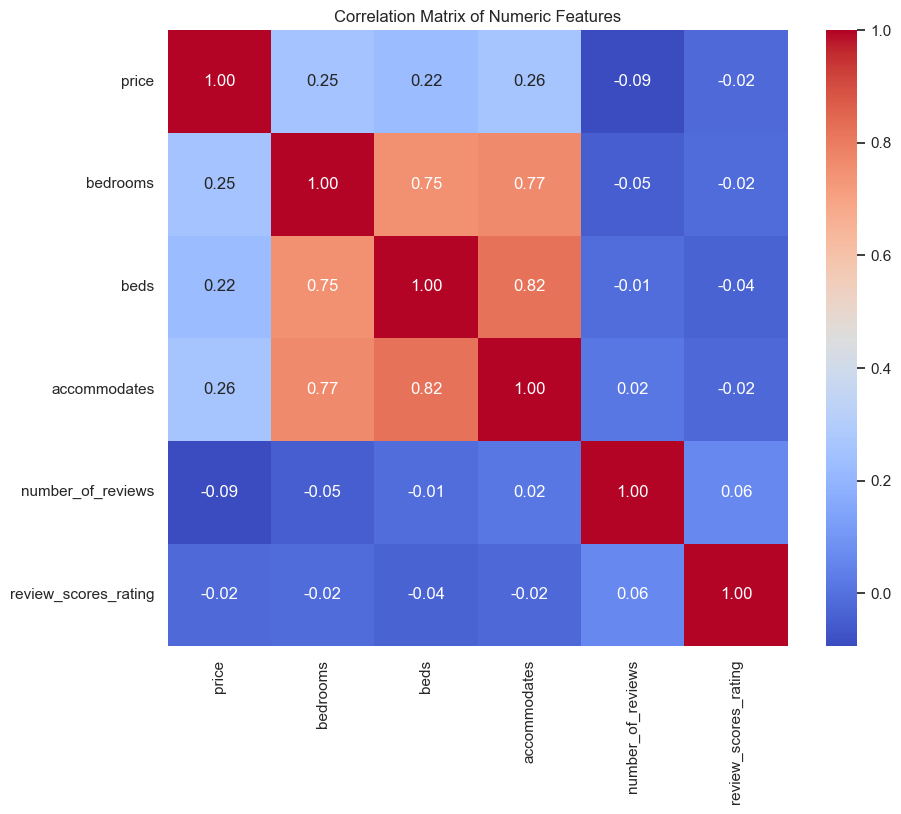

In [104]:
# correlation heatmap
numeric_cols = ['price', 'bedrooms', 'beds', 'accommodates', 'number_of_reviews', 'review_scores_rating']
corr_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [105]:
# Amenities
df_clean['amenities_list'] = df_clean['amenities'].str.split(', ')
# Count the frequency of each amenity
amenities_list = [amenity.strip() for sublist in df_clean['amenities_list'] for amenity in sublist if amenity]
amenity_counts = Counter(amenities_list)
most_common_amenities = dict(amenity_counts.most_common(50))

# Plotting the most common amenities
plt.figure(figsize=(12, 8))
# Using the `color` parameter instead of `palette`
sns.barplot(x=list(most_common_amenities.values()), y=list(most_common_amenities.keys()), color='lightblue')
plt.title('Top 10 Most Common Amenities')
plt.xlabel('Frequency')
plt.ylabel('Amenity')
plt.tight_layout()  # Adjust layout
PLOT_FILENAME_AVAILABILITY = 'top_comon_amenities.png'
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline

# Define the title text
TITLE_TEXT = "Top Common Amenities"

# Path to the image
PATH = 'top_comon_amenities.png'

add_slide_with_title_and_image(prs,TITLE_TEXT,PATH)


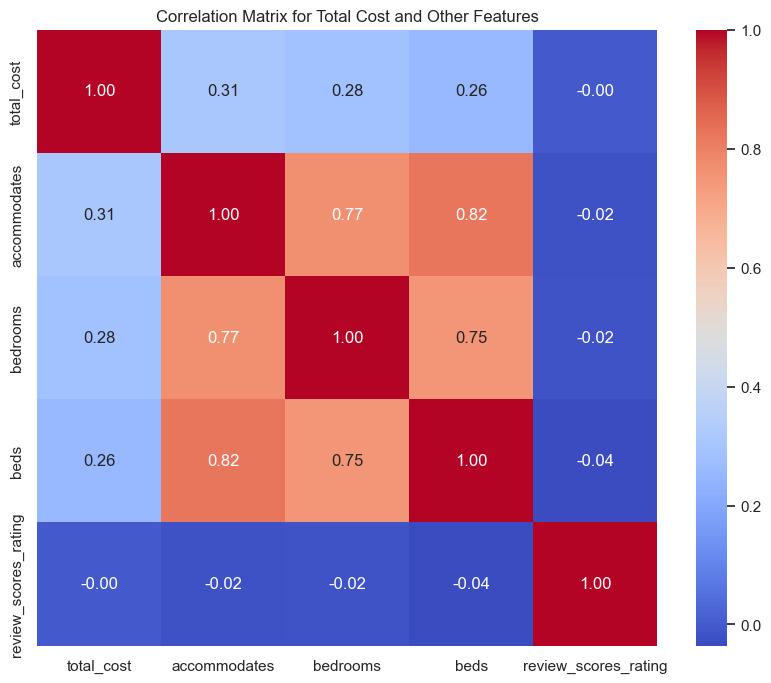

In [106]:
# This code in the cell focuses on calculating the total cost for each listing and examining the relationships between total cost and other numerical 
#features of the listings, such as accommodation capacity and reviews. 
#Additionally, it visualizes these relationships using correlation matrices and scatter plots, 
# and incorporates the results into a PowerPoint presentation.

df_clean['total_cost'] = df_clean['price'] + df_clean['cleaning_fee'].fillna(0) + df_clean['extra_people'].fillna(0)

# Correlation between total cost and other numerical features
correlation_features = ['total_cost', 'accommodates', 'bedrooms', 'beds', 'review_scores_rating']
correlation_matrix = df_clean[correlation_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Total Cost and Other Features')
plt.show()

# Scatter plot of total cost vs. accommodates
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='accommodates', y='total_cost', alpha=0.6)
plt.title('Total Cost vs. Accommodates')
plt.xlabel('Accommodates')
plt.ylabel('Total Cost')
plt.tight_layout()  # Adjust layout
PLOT_FILENAME_AVAILABILITY = 'Total_Cost.png'
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline

# Define the title text and position
TITLE_TEXT = "Total Cost Vs. Accommodates"

# Path to the image you want to add
PATH = 'Total_Cost.png'

#slide.shapes.add_picture(img_path_availability, image_left, image_top, width=image_width, height=image_height)

add_slide_with_title_and_image(prs,TITLE_TEXT,PATH)

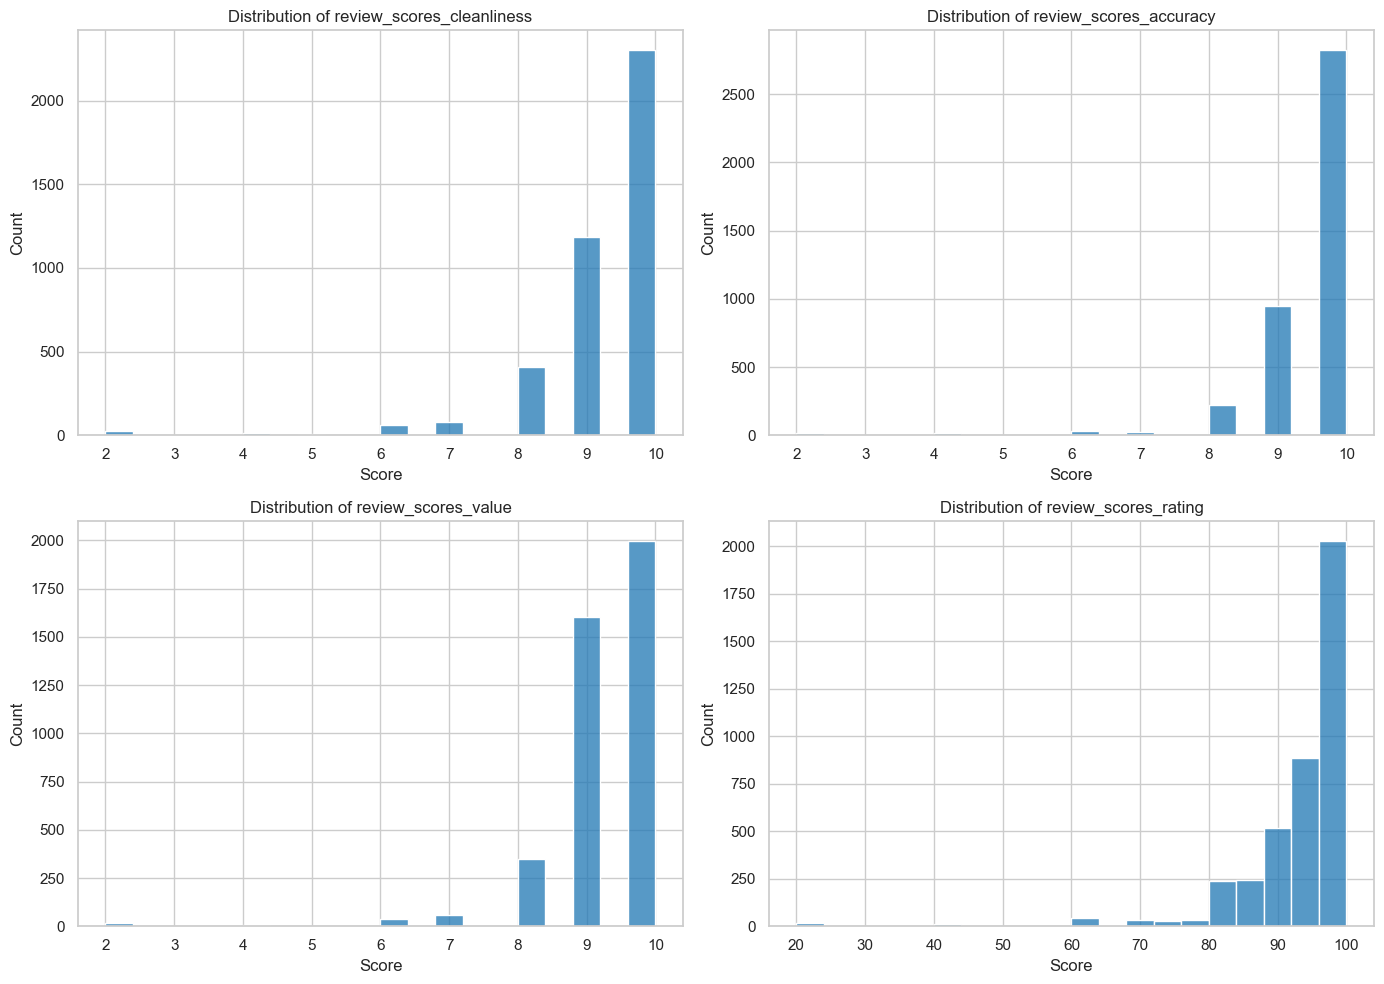

In [107]:
#The code efficiently combines data manipulation, statistical analysis, visualization, and presentation integration 
#to provide a comprehensive analysis of review scores in relation to pricing in the listings dataset. 
#It is particularly useful for data-driven decision-making where understanding customer satisfaction and its impact 
# on financial outcomes is crucial.
#Defines a list of column names that correspond to different review score metrics in the DataFrame. 
#These categories are used to guide subsequent analysis and visualizations.
#review_categories = ['review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_value', 'review_scores_rating']
# Generates histograms for each review score category to visualize the frequency distribution of scores.
#Details:
#Each histogram is plotted in a separate subplot within a 2x2 grid, facilitating easy comparison across different types of review scores.
#sns.histplot is used to create histograms with 20 bins each, which provides a detailed view of the distribution.
#KDE (Kernel Density Estimate) is turned off to focus solely on the histogram.

    
# Distribution of review scores
plt.figure(figsize=(14, 10))
review_categories = ['review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_value', 'review_scores_rating']
for i, category in enumerate(review_categories, start=1):
    plt.subplot(2, 2, i)
    sns.histplot(df_clean[category], bins=20, kde=False)
    plt.title(f'Distribution of {category}')
    plt.xlabel('Score')
    plt.ylabel('Count')

plt.tight_layout()

# Correlation between review scores and price/total cost
review_corr_features = review_categories + ['price', 'total_cost']
review_corr_matrix = df_clean[review_corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(review_corr_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Distribution of Review Scores')

plt.tight_layout()  # Adjust layout
PLOT_FILENAME_AVAILABILITY = 'Distribution_of_Review_Scores.png'
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline
# Define the title text
TITLE_TEXT = "Distribution of Review Scores"

# Path to the image
PATH = 'Distribution_of_Review_Scores.png'

add_slide_with_title_and_image(prs,TITLE_TEXT,PATH)

In [108]:

# Select numeric columns from the DataFrame
numeric_cols = df_clean.select_dtypes(include=['number'])

# Calculate variance for each numeric column
variances = numeric_cols.var()

# Initialize an empty string to capture the formatted output
OUTPUT_TEXT = "Variance Analysis of Numeric Columns\n\n"

# Format each variance entry with better readability
for column, variance in variances.items():
    OUTPUT_TEXT += f"- {column.replace('_', ' ').title()} Variance: {variance:.2f}\n"

# Add a slide with the captured text to the presentation
TITLE = "Variance Analysis of Numeric Columns"

add_slide_with_title_and_two_columns(prs, TITLE, OUTPUT_TEXT)

In [109]:
# The code converts date fields into a more usable format, calculates occupancy rates, and visualizes these rates over 
# the months using line plots. 

# Step 1: Convert 'first_review' and 'last_review' to datetime
df_clean['first_review'] = pd.to_datetime(df_clean['first_review'])
df_clean['last_review'] = pd.to_datetime(df_clean['last_review'])

# Step 2: Extract month from 'first_review' and 'last_review'
df_clean['first_review_month'] = df_clean['first_review'].dt.month
df_clean['last_review_month'] = df_clean['last_review'].dt.month

# Step 3: Calculate occupancy rate (as provided)
df_clean['occupancy_rate'] = 1 - (df_clean['availability_availability_365'] / 365)

# Prepare separate DataFrames for first and last review months
df_first = df_clean[['first_review_month', 'occupancy_rate']].rename(columns={'first_review_month': 'month'})
df_last = df_clean[['last_review_month', 'occupancy_rate']].rename(columns={'last_review_month': 'month'})

# Combine the two DataFrames, ignoring NaN values
df_combined = pd.concat([df_first.dropna(), df_last.dropna()])

# Step 5: Group by month and calculate mean occupancy rate
monthly_occupancy = df_combined.groupby('month')['occupancy_rate'].mean().reset_index()

# Step 6: Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_occupancy, x='month', y='occupancy_rate', marker='o')
plt.title('Occupancy Rate by Month')
plt.xlabel('Month')
plt.ylabel('Occupancy Rate')
plt.xticks(ticks=range(1, 13), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.grid(True)
plt.tight_layout()  # Adjust layout
PLOT_FILENAME_AVAILABILITY = 'OccupancyRatebyMonthFirstandLastReviews.png'
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot

plt.close()  # Close the plot to prevent displaying it inline
# Define the title text
TITLE_TEXT = "Occupancy Rate by Month (First and Last Reviews"

# Path to the image
PATH = 'OccupancyRatebyMonthFirstandLastReviews.png'

add_slide_with_title_and_image(prs,TITLE_TEXT,PATH)


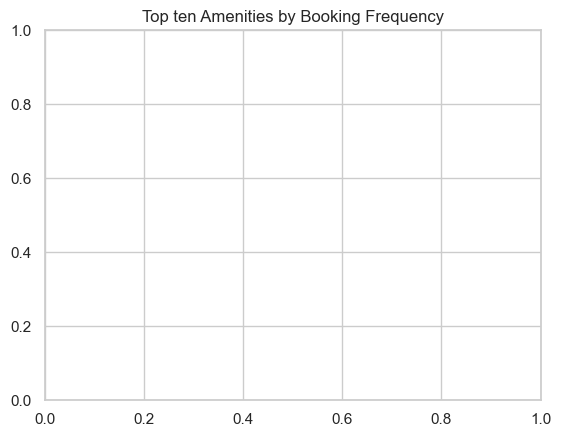

In [110]:
#This code effectively transforms a raw list of amenities into a meaningful analysis of how different amenities 
#impact the popularity of listings, as measured by reviews, and presents the findings in a visually appealing and understandable format.

df_clean['amenities_list'] = df_clean['amenities'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
df_amenities_exploded = df_clean.explode('amenities_list').rename(columns={'amenities_list': 'amenity'})

# Now that each amenity is associated with a listing, calculate the mean number of reviews per amenity
amenity_reviews = df_amenities_exploded.groupby('amenity')['number_of_reviews'].mean().sort_values(ascending=False).head(10)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(y=amenity_reviews.index, x=amenity_reviews.values, color='cyan')
plt.title('Top 10 Amenities by Booking Frequency (Proxy: Number of Reviews)')
plt.xlabel('Average Number of Reviews')
plt.ylabel('Amenity')
plt.tight_layout()  # Adjust layout
PLOT_FILENAME_AVAILABILITY = 'ToptenAmenitiesbyBookingFrequency.png'
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline
plt.title('Top ten Amenities by Booking Frequency')
# Define the title text 
TITLE_TEXT = "Top ten Amenities by Booking Frequency"

# Path to the image 
PATH = 'ToptenAmenitiesbyBookingFrequency.png'

add_slide_with_title_and_image(prs,TITLE_TEXT,PATH)

In [111]:
df_clean['first_review_date'] = pd.to_datetime(df_clean['first_review'], unit='ms')
df_clean['last_review_date'] = pd.to_datetime(df_clean['last_review'], unit='ms')

# Extracting city and country
df_clean['city'] = df_clean['address'].apply(lambda x: x['street'].split(',')[0])  # Simplistic extraction, adjust as needed
df_clean['country'] = df_clean['address'].apply(lambda x: x['country'])

# Selecting relevant columns to display
df_final = df_clean[['city', 'country', 'first_review_date', 'last_review_date']]

print(df_final)

                city        country   first_review_date    last_review_date
0              Porto       Portugal 2016-01-03 05:00:00 2019-01-20 05:00:00
1     Rio de Janeiro         Brazil                 NaT                 NaT
2           Honolulu  United States 2013-05-24 04:00:00 2019-02-07 05:00:00
3           Brooklyn  United States 2016-01-31 05:00:00 2016-01-31 05:00:00
4     Rio de Janeiro         Brazil                 NaT                 NaT
...              ...            ...                 ...                 ...
5550           Porto       Portugal 2016-01-03 05:00:00 2019-02-07 05:00:00
5551         Kadıköy         Turkey                 NaT                 NaT
5552  Rio de Janeiro         Brazil 2016-01-06 05:00:00 2019-01-27 05:00:00
5553         Lahaina  United States 2015-08-17 04:00:00 2018-08-06 04:00:00
5554         Lahaina  United States 2016-04-06 04:00:00 2018-08-20 04:00:00

[5554 rows x 4 columns]


In [112]:
print("Columns in DataFrame:", df_final.columns)
#city_distribution = df['city'].value_counts()

# Display the distribution
#print(city_distribution)

Columns in DataFrame: Index(['city', 'country', 'first_review_date', 'last_review_date'], dtype='object')


In [113]:
# The code belwo performs a series of operations to visualize the distribution of listings across different cities 
# from a dataset. 

# Set the visual style of the plots
sns.set(style="whitegrid")

# Plotting the distribution of listings across cities
plt.figure(figsize=(10, 8))
city_distribution = df_final['city'].value_counts().nlargest(10)  # You might want to limit to the top 10 cities for clarity
ax = sns.barplot(x=city_distribution.values, y=city_distribution.index, palette="coolwarm")
plt.title('Distribution of Listings Across Cities')
plt.xlabel('Number of Listings')
plt.ylabel('City')
for i, value in enumerate(city_distribution.values):
    ax.text(value, i, f'{value}', va='center')
plt.tight_layout()  # Adjust layout
PLOT_FILENAME_AVAILABILITY = 'DistributionofListingsAcrossCities.png'
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline
# Define the title text
TITLE_TEXT = "Distribution of Listings Across Cities"

# Path to the image
PATH = 'DistributionofListingsAcrossCities.png'


add_slide_with_title_and_image(prs,TITLE_TEXT,PATH)

/var/folders/h1/_7xrrb6901zclwx0hy1h5vh40000gn/T/ipykernel_49238/525434434.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=city_distribution.values, y=city_distribution.index, palette="coolwarm")


In [114]:
highest_total_cost_record = df_clean[df_clean['total_cost'] == df_clean['total_cost'].max()]

# Display the record
print(highest_total_cost_record)

           _id                            listing_url  \
860   14644562  https://www.airbnb.com/rooms/14644562   
3391  27593455  https://www.airbnb.com/rooms/27593455   

                              name  \
860                      良德街3号温馨住宅   
3391  HS1-2人大床房+丰泽､苏宁､百脑汇+女人街+美食中心   

                                                summary space  \
860   我的房源靠近风景｡因为温馨简单,您一定会爱上我的房源｡我的房源适合情侣､独自旅行的冒险家､商...         
3391  有獨立的衛生間! 交通便利,去哪裡都方便:距離旺角地鐵站E1出口僅100米,楼下步行5秒即是...         

                                            description  \
860   我的房源靠近风景｡因为温馨简单,您一定会爱上我的房源｡我的房源适合情侣､独自旅行的冒险家､商...   
3391  有獨立的衛生間! 交通便利,去哪裡都方便:距離旺角地鐵站E1出口僅100米,楼下步行5秒即是...   

                                  neighborhood_overview  \
860                                                       
3391  旺角位于九龙半岛的北部,著名的弥敦道贯穿其中,这里是香港人气最旺盛的地区之一,潮流时尚､传统...   

                                                  notes  \
860                                                       
3391  入住時間為下午2點,退房時間為次日中午12點(我們需要在您退房之後做保潔,

In [115]:
#performs a series of operations aimed at preparing and analyzing financial data from a dataset, 
#specifically focusing on the cost associated with rental listings, including additional fees for extra people.
                                                                                                                                                                                          
#It concludes by visualizing the data and incorporating the results into a PowerPoint presentation. 
df_clean['price'] = pd.to_numeric(df_clean['price'], errors='coerce')
df_clean['extra_people'] = pd.to_numeric(df_clean['extra_people'], errors='coerce')

# Calculate total cost including extra people fee
df_clean['total_cost_including_extra'] = df_clean['price'] + df_clean['extra_people'].fillna(0)
sns.scatterplot(data=df_clean, x='accommodates', y='total_cost_including_extra', alpha=0.6)
plt.title('Price vs. Accommodates Including Extra People Fee')
plt.xlabel('Accommodates')
plt.ylabel('Total Cost Including Extra People Fee')
plt.tight_layout()  # Adjust layout
PLOT_FILENAME_AVAILABILITY = 'PriceAccommodatesIncludingExtraPeopleFee.png'
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline
# Define the title text 
TITLE_TEXT = "Price vs. Accommodates Including Extra People Fee"

# Path to the image 
PATH = 'PriceAccommodatesIncludingExtraPeopleFee.png'

add_slide_with_title_and_image(prs,TITLE_TEXT,PATH)

In [116]:
df_clean_filtered = df_clean.loc[df_clean['_id'] != 20275354]

In [117]:
sorted_df = df_clean[['price', '_id']].sort_values(by='price', ascending=True)

# Display the sorted DataFrame
print(sorted_df)

        price       _id
873       9.0  14758068
4391     10.0  32636126
4123     10.0  31305846
2018     10.0  20611485
2839     12.0  24450419
...       ...       ...
3927  10001.0  30327756
2386  10001.0  22200454
737   11190.0  13997910
3391  11681.0  27593455
860   11681.0  14644562

[5554 rows x 2 columns]


In [118]:
df_clean['_id'] = df_clean['_id'].astype(str)

# Filter out the record with _id '20275354'
df_clean_filtered = df_clean.loc[df_clean['_id'] != '20275354']

In [119]:
sorted_df = df_clean_filtered[['price', '_id']].sort_values(by='price', ascending=True)

# Display the sorted DataFrame
print(sorted_df)

        price       _id
873       9.0  14758068
4391     10.0  32636126
4123     10.0  31305846
2018     10.0  20611485
2839     12.0  24450419
...       ...       ...
3927  10001.0  30327756
2386  10001.0  22200454
737   11190.0  13997910
3391  11681.0  27593455
860   11681.0  14644562

[5554 rows x 2 columns]


In [120]:
# Filter listings with zero bedrooms
zero_bedroom_listings = df_clean[df_clean['bedrooms'] == 0]

# Count the number of listings with zero bedrooms
num_zero_bedroom_listings = zero_bedroom_listings.shape[0]

# Display the count
print(f"Number of listings with zero bedrooms: {num_zero_bedroom_listings}")

# If you also want to see the prices of these listings:
print("Prices of listings with zero bedrooms:")
print(zero_bedroom_listings['price'])

Number of listings with zero bedrooms: 0
Prices of listings with zero bedrooms:
Series([], Name: price, dtype: float64)


In [121]:
zero_bed_listings = df_clean[df_clean['beds'] == 0]

# Count the number of listings with zero beds
num_zero_bed_listings = zero_bed_listings.shape[0]

# Display the count
print(f"Number of listings with zero beds: {num_zero_bed_listings}")

# If you want to see the prices of these listings:
print("Prices of listings with zero beds:")
print(zero_bed_listings['price'])

average_price_by_beds = df_clean.groupby('beds')['price'].mean()

# Display the average prices
print("Average price by number of beds:")
print(average_price_by_beds)

Number of listings with zero beds: 29
Prices of listings with zero beds:
100     135.0
318      99.0
396      42.0
620     119.0
740     486.0
787      70.0
830     200.0
857      40.0
996      78.0
1166    194.0
1317    109.0
1450    469.0
1499    125.0
1605    350.0
1869     86.0
1974     45.0
2159     68.0
2208    125.0
2568    200.0
2625    148.0
3295    200.0
3731    119.0
4004    140.0
4025    210.0
4471    127.0
4474    105.0
4670     80.0
4789    136.0
4987    150.0
Name: price, dtype: float64
Average price by number of beds:
beds
0.0      153.620690
1.0      198.519912
2.0      234.272991
3.0      358.929985
4.0      408.410390
5.0      544.891566
6.0      598.816514
7.0      768.860465
8.0      586.714286
9.0      495.545455
10.0     719.937500
11.0     621.333333
12.0     251.800000
13.0     320.000000
14.0     240.500000
15.0    2929.500000
16.0    1291.500000
18.0    5502.000000
25.0     227.000000
Name: price, dtype: float64


In [122]:
#Data Aggregation: The code first groups the df_clean DataFrame by 'city', 'property_type', and 'beds' columns and then 
#calculates the mean 'price' for each group. This operation generates a new DataFrame (grouped_data) that summarizes 
#the average price for listings based on their city, property type, and number of beds. This grouped data is helpful 
#for understanding how property characteristics influence pricing in different locations.
#Data Filtering: From the aggregated data, the code filters out a specific subset where the city is 'Barcelona' and 
#the property type is 'Apartment'. This focused subset (specific_data) allows for a more detailed analysis of how the
#number of beds affects the average price in a specific market segment.
#Visualization: It then visualizes the relationship between the number of beds and the average price for the filtered 
#data using a line plot. This graph provides a visual representation of pricing trends within the specified category,
#helping to identify if additional beds correlate with higher or lower prices.

grouped_data = df_clean.groupby(['city', 'property_type', 'beds'])['price'].mean().reset_index()

# Display the first few rows of the grouped data
print(grouped_data.head())
specific_data = grouped_data[(grouped_data['city'] == 'Barcelona') & (grouped_data['property_type'] == 'Apartment')]

# Visualize the relationship between number of beds and average price

plt.figure(figsize=(10, 6))
sns.lineplot(data=specific_data, x='beds', y='price', marker='o')
plt.title('Average Price by Number of Beds in SpecificCity for Houses')
plt.xlabel('Number of Beds')
plt.ylabel('Average Price')
plt.tight_layout()  # Adjust layout
PLOT_FILENAME_AVAILABILITY = 'AveragePricebyNumberofBeds.png'
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline
# Define the title text 
TITLE_TEXT = "Average Price by Number of Beds in Houses"

# Path to the image 
PATH = 'AveragePricebyNumberofBeds.png'


add_slide_with_title_and_image(prs,TITLE_TEXT,PATH)

     city      property_type  beds   price
0  ADALAR  Bed and breakfast   1.0  2979.0
1  Adalar          Apartment   1.0   169.0
2  Adalar          Apartment   3.0   169.0
3  Adalar             Chalet   4.0   401.0
4  Adalar       Nature lodge   1.0   100.0


In [123]:
# Visualizing the verification status
sns.countplot(data=df_clean, x='host_identity_verified', palette='coolwarm')
plt.title('Host Identity Verification Status')
plt.xlabel('Is Identity Verified?')
plt.ylabel('Count')
plt.tight_layout()  # Adjust layout
PLOT_FILENAME_VERIFICATION = 'HostVerification.png'
plt.savefig(PLOT_FILENAME_VERIFICATION, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline
# Define the title text 
TITLE_TEXT = "Host Identity Verification Report"

# Path to the image 
PATH = 'HostVerification.png'

add_slide_with_title_and_image(prs,TITLE_TEXT,PATH)


/var/folders/h1/_7xrrb6901zclwx0hy1h5vh40000gn/T/ipykernel_49238/3982006404.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='host_identity_verified', palette='coolwarm')


In [124]:
# Analyzing Response Time
response_time_analysis = df_clean['host_response_time'].value_counts()
print("Response Time Analysis:\n", response_time_analysis)

# Visualizing Response Time Distribution
sns.countplot(data=df_clean, x='host_response_time', palette='viridis')
plt.title('Response Time Distribution')
plt.xlabel('Response Time')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.tight_layout()  # Adjust layout
PLOT_FILENAME_VERIFICATION = 'ResponseTime.png'
plt.savefig(PLOT_FILENAME_VERIFICATION, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline
# Define the title text 
TITLE_TEXT = "Response Time From Host"

# Path to the image 
PATH = 'ResponseTime.png'

add_slide_with_title_and_image(prs,TITLE_TEXT,PATH)


/var/folders/h1/_7xrrb6901zclwx0hy1h5vh40000gn/T/ipykernel_49238/3411256266.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='host_response_time', palette='viridis')


Response Time Analysis:
 host_response_time
within an hour        2715
No response           1387
within a few hours     742
within a day           566
a few days or more     144
Name: count, dtype: int64


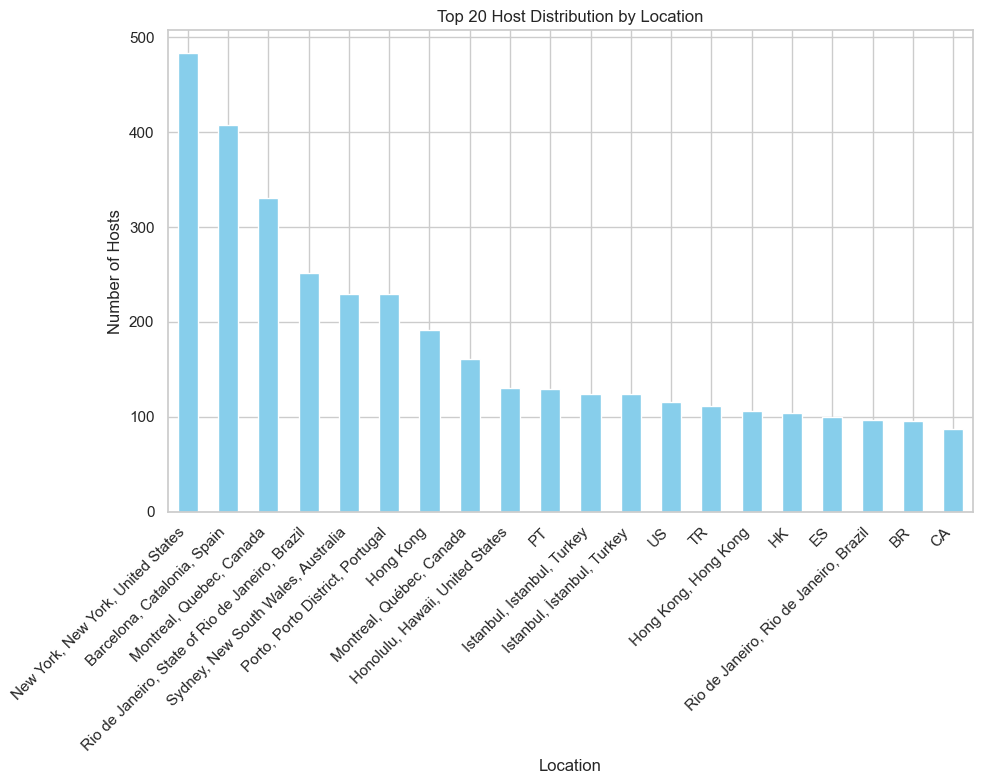

In [125]:

# Get the top 20 locations
location_analysis = df_clean.groupby('host_location').size()
top_locations = location_analysis.sort_values(ascending=False).head(20)

# Plotting
plt.figure(figsize=(10, 8))
top_locations.plot(kind='bar', color='skyblue')
plt.title('Top 20 Host Distribution by Location')
plt.xlabel('Location')
plt.ylabel('Number of Hosts')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.tight_layout()  # Adjust layout
PLOT_FILENAME_VERIFICATION = 'HostDistribution.png'
plt.savefig(PLOT_FILENAME_VERIFICATION, bbox_inches='tight')  # Save the plot

# Define the title text 
TITLE_TEXT = "Host Distribution By Location"

# Path to the image 
PATH = 'HostDistribution.png'

add_slide_with_title_and_image(prs,TITLE_TEXT,PATH)
plt.show()


In [126]:
columns_of_interest = ['review_scores_accuracy', 'review_scores_cleanliness',
                       'review_scores_checkin', 'review_scores_communication',
                       'review_scores_location', 'review_scores_value',
                       'price', 'cleaning_fee', 'bathrooms']

# Calculate correlation matrix
correlation_matrix = df_clean[columns_of_interest].corr()

# Display the correlation matrix
print(correlation_matrix)

                             review_scores_accuracy  \
review_scores_accuracy                     1.000000   
review_scores_cleanliness                  0.664999   
review_scores_checkin                      0.631432   
review_scores_communication                0.646412   
review_scores_location                     0.496290   
review_scores_value                        0.723412   
price                                     -0.058196   
cleaning_fee                               0.037874   
bathrooms                                  0.017731   

                             review_scores_cleanliness  review_scores_checkin  \
review_scores_accuracy                        0.664999               0.631432   
review_scores_cleanliness                     1.000000               0.535909   
review_scores_checkin                         0.535909               1.000000   
review_scores_communication                   0.541829               0.715857   
review_scores_location                      

In [127]:
# Initialize an empty string to capture the output with a heading
OUTPUT_TEXT = "Review Scores Analysis\n\n"

# Add a subheading for the first set of columns
OUTPUT_TEXT += "Review Scores Breakdown:\n"

# First set of columns
review_score_columns = ['review_scores_accuracy', 'review_scores_cleanliness',
                        'review_scores_checkin', 'review_scores_communication',
                        'review_scores_location', 'review_scores_value']

for column in review_score_columns:
    more_than_8 = (df_clean[column] > 8.0).sum()
    less_than_5 = (df_clean[column] < 5.0).sum()
    OUTPUT_TEXT += f"- {column.replace('_', ' ').title()}:\n    More than 8.0: {more_than_8}\n    Less than 5.0: {less_than_5}\n"

# Add a subheading for the 'beds' column
OUTPUT_TEXT += "\nBeds Score Analysis:\n"

# Second set for 'beds' column
review_score_columns = ['beds']

for column in review_score_columns:
    more_than_7 = (df_clean[column] > 7.0).sum()
    less_than_9 = (df_clean[column] < 9.0).sum()
    OUTPUT_TEXT += f"- {column.title()}:\n    More than 7.0: {more_than_7}\n    Less than 9.0: {less_than_9}\n"

# Use the function to add this content to the presentation
add_slide_with_title_and_two_columns(prs, "Review Scores and Beds Analysis", OUTPUT_TEXT)


In [128]:

local_slide = add_new_slide_with_title(prs, "")


if local_slide.shapes.title:
    title_shape = local_slide.shapes.title
else:
    # Add a title shape if it does not exist
    title_shape = local_slide.shapes.add_textbox(Inches(1), Inches(1), Inches(8), Inches(1))
    title_shape.text = "Data Observations"
# Center the title
for paragraph in title_shape.text_frame.paragraphs:
    paragraph.alignment = PP_ALIGN.CENTER

# Set the font size for the title
for run in title_shape.text_frame.paragraphs[0].runs:
    run.font.size = Pt(44)  # Example size, adjust as needed

# Add bullet points
txBox = local_slide.shapes.add_textbox(Inches(2), Inches(2), Inches(6), Inches(4))
tf = txBox.text_frame

# Text to add as bullet points
points = [
    "Numeric data has different formats like dictionary.",
    "Several data elements like datetime need to be transformed.",
    "There are several numeric fields have null or NaN values in it.",
    "Flattening is required in some cases."
]

for point in points:
    p = tf.add_paragraph()
    p.text = point
    p.space_after = Inches(0.1)
    # Center the bullet points
    p.alignment = PP_ALIGN.LEFT


In [129]:
# Load the CSV file and assign column names
data = []
with open('translated_review_comments.txt', 'r') as file:
    for line in file:
        parts = line.strip().split(' ', 2)  # Split only on the first two spaces
        if len(parts) == 3:  # Ensure no lines with missing data
            data.append(parts)
df = pd.DataFrame(data, columns=['propertyID', 'reviewID', 'comment'])

df.describe()

,propertyID,reviewID,comment
count,122853,122853,122853
unique,3408,122849,120103
top,4069429,182134929,No features in text.
freq,533,2,147


In [130]:
# Basic cleaning and preprocessing
# Assuming 'comment' column contains the text reviews
df['cleaned_comments'] = df['comment'].str.lower()
df['cleaned_comments'] = df['cleaned_comments'].apply(lambda x: re.sub(r'\d+', '', x))  # remove numbers
df['cleaned_comments'] = df['cleaned_comments'].apply(lambda x: re.sub(r'[^\w\s]', '', x))  # remove punctuation
df['cleaned_comments'] = df['cleaned_comments'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))]))

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['cleaned_comments'] = df['cleaned_comments'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
df.to_csv("cleaned_review_comments.csv",index=False)

In [131]:
# Vectorization

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleaned_comments'])


In [132]:
import matplotlib.pyplot as plt
# Elbow Method to find the optimal number of clusters
sse = {}
for k in range(2, 15):  # Adjust the range as needed
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_  # Sum of squared distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow Method For Optimal k")
plt.tight_layout()  # Adjust layout
PLOT_FILENAME_AVAILABILITY = 'ElbowMethod.png'
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline

# Define the title text and position
TITLE_TEXT = "Elbow Method For Optimal k"

# Path to the image you want to add
PATH = 'ElbowMethod.png'

#slide.shapes.add_picture(img_path_availability, image_left, image_top, width=image_width, height=image_height)

add_slide_with_title_and_image(prs,TITLE_TEXT,PATH)
plt.show()

In [133]:

from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt


# Initialize TruncatedSVD to reduce to 2 dimensions for visualization
svd = TruncatedSVD(n_components=2)

# Fit TruncatedSVD on the TF-IDF matrix
tfidf_svd = svd.fit_transform(X)  # No need to convert to dense array

# Optionally, visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(tfidf_svd[:, 0], tfidf_svd[:, 1], edgecolor='k', alpha=0.5)
plt.title('SVD Result')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.tight_layout()  # Adjust layout
PLOT_FILENAME_AVAILABILITY = 'SVDResult.png'
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline

# Define the title text and position
TITLE_TEXT = "SVD Result"

# Path to the image you want to add
PATH = 'SVDResult.png'

#slide.shapes.add_picture(img_path_availability, image_left, image_top, width=image_width, height=image_height)

add_slide_with_title_and_image(prs,TITLE_TEXT,PATH)
plt.show()

In [134]:
feature_names = vectorizer.get_feature_names_out()  # Get the feature names (words)
for i in range(2):  # We are only interested in the first two components here
    print(f"Top terms in Component {i+1}:")
    component_terms = dict(zip(feature_names, svd.components_[i]))
    sorted_terms = sorted(component_terms.items(), key=lambda x: x[1], reverse=True)
    for term, weight in sorted_terms[:10]:  # Show top 10 terms
        print(f"{term}: {weight:.4f}")
    print("\n")

Top terms in Component 1:
great: 0.3854
place: 0.2714
location: 0.2605
stay: 0.2288
apartment: 0.2224
nice: 0.1791
clean: 0.1773
host: 0.1736
good: 0.1734
everything: 0.1354


Top terms in Component 2:
great: 0.7541
location: 0.2760
place: 0.1176
host: 0.0416
value: 0.0286
stay: 0.0222
awesome: 0.0146
spot: 0.0124
communication: 0.0104
amazing: 0.0064




In [135]:
from sklearn.cluster import KMeans

# Assuming 'tfidf_svd' contains your SVD-transformed TF-IDF data
# Let's cluster the documents into, for example, 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(tfidf_svd)
print(clusters)

# Now 'clusters' contains the cluster labels for each document

[0 0 0 ... 3 0 0]


In [136]:
import matplotlib.pyplot as plt

# Plotting the document clusters in SVD topic space
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tfidf_svd[:, 0], tfidf_svd[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('Component 1: Accommodation Quality')
plt.ylabel('Component 2: Strategic Location and Communication')
plt.title('Document Clusters in SVD Topic Space')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()  # Adjust layout
PLOT_FILENAME_AVAILABILITY = 'Clusters.png'
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline

# Define the title text and position
TITLE_TEXT = "Clusters in SVD Topic Space"

# Path to the image you want to add
PATH = 'Clusters.png'

#slide.shapes.add_picture(img_path_availability, image_left, image_top, width=image_width, height=image_height)

add_slide_with_title_and_image(prs,TITLE_TEXT,PATH)
plt.show()


In [137]:
from sklearn.decomposition import LatentDirichletAllocation

# Number of topics
n_topics = 5  # This is an example; replace with the number of clusters you determined

# Initialize and fit LDA model
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', random_state=0)
lda.fit(X)
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
value money recommendable watch victor sol nicole michele lisa total
Topic 1:
great good location nice place convenient landlord stay hong kong
Topic 2:
cottage unbeatable michael appartement al swimming efficient pablo farm exceeded
Topic 3:
almost noise cold due bit comfort however toilet ok neighbor
Topic 4:
great place apartment stay location host clean nice everything recommend


In [138]:
import numpy as np
import pandas as pd
lda_topics = lda.fit_transform(X)
# Assume 'lda_topics' and 'clusters' are arrays from the above steps
topic_assignments = np.argmax(lda_topics, axis=1)  # Get the dominant topic for each document
association_matrix = np.zeros((5, 5))  # Adjust size as per the number of topics/clusters

for topic, cluster in zip(topic_assignments, clusters):
    association_matrix[topic, cluster] += 1

# Convert to DataFrame for better readability
association_df = pd.DataFrame(association_matrix, index=[f"Topic {i}" for i in range(5)],
                              columns=[f"Cluster {j}" for j in range(5)])
print(association_df)

         Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4
Topic 0      695.0       58.0       42.0       13.0        5.0
Topic 1     1303.0      666.0      734.0     1383.0     1107.0
Topic 2      212.0       25.0       48.0        3.0        0.0
Topic 3     1149.0       39.0      124.0       38.0        0.0
Topic 4    43553.0     6727.0    27834.0    36798.0      297.0


In [139]:

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'association_matrix' is your DataFrame
plt.figure(figsize=(10, 8))
sns.heatmap(association_matrix, annot=True, fmt=".0f", cmap='Blues', cbar_kws={'label': 'Number of Documents'})
plt.title('Cross-tabulation of LDA Topics and K-means Clusters')
plt.xlabel('K-means Clusters')
plt.ylabel('LDA Topics')
plt.tight_layout()  # Adjust layout
PLOT_FILENAME_AVAILABILITY = 'K-MeansClusters.png'
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline

# Define the title text and position
TITLE_TEXT = "K-Means Clusters"

# Path to the image you want to add
PATH = 'K-MeansClusters.png'

#slide.shapes.add_picture(img_path_availability, image_left, image_top, width=image_width, height=image_height)

add_slide_with_title_and_image(prs,TITLE_TEXT,PATH)
plt.show()

In [140]:
from sklearn.decomposition import LatentDirichletAllocation

# Number of topics
n_topics = 4  # This is an example; replace with the number of clusters you determined

# Initialize and fit LDA model
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', random_state=0)
lda.fit(X)
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
value good money smooth unbeatable mr recommendable kok mong manly
Topic 1:
appartment parent bondi al confortable mario peter ok position responding
Topic 2:
place great stay apartment location room clean host nice good
Topic 3:
great location place apartment stay nice clean host good recommend


In [141]:
import nltk
from nltk.corpus import stopwords
import string

combined_comments = " ".join(df['comment'].astype(str).tolist())
# Download stopwords if not already downloaded
nltk.download('stopwords')

# Function to clean text
def clean_text(text):
    # Convert text to lower case
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Clean the combined comments
cleaned_comments = clean_text(combined_comments)
df['cleaned_comment'] = df['comment'].apply(clean_text)  # Using the previously defined clean_text function

# Now save the DataFrame to a CSV file
df.to_csv('cleaned_comments.csv', index=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sanjayv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [142]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create and display a word cloud
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(cleaned_comments)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()  # Adjust layout
PLOT_FILENAME_AVAILABILITY = 'WordCloud.png'
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline

# Define the title text and position
TITLE_TEXT = "Word Cloud"

# Path to the image you want to add
PATH = 'WordCloud.png'

#slide.shapes.add_picture(img_path_availability, image_left, image_top, width=image_width, height=image_height)

add_slide_with_title_and_image(prs,TITLE_TEXT,PATH)
plt.show()

In [143]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk import bigrams, trigrams

# Sample text
text = cleaned_comments

# Tokenize the text
words = word_tokenize(text.lower())  # convert to lower case to normalize

text = re.sub(r"’", "'", text)  # Standardize apostrophes
words = text.lower().split()
filtered_words = [word for word in words if word not in stopwords.words('english') and word.isalpha()]

# Optionally, remove less informative words manually
filtered_words = [word for word in filtered_words if word not in ['us']]

# Recount frequencies
word_counts = Counter(filtered_words)
# Display the 10 most common words
print(word_counts.most_common(10))
# Bi-gram analysis
bi_grams = list(bigrams(filtered_words))
bi_gram_counts = Counter(bi_grams)
print("\nBi-grams Frequencies:")
print(bi_gram_counts.most_common(10))

# Tri-gram analysis
tri_grams = list(trigrams(filtered_words))
tri_gram_counts = Counter(tri_grams)
print("\nTri-grams Frequencies:")
print(tri_gram_counts.most_common(10))

[('great', 64876), ('apartment', 53896), ('place', 53188), ('stay', 52348), ('location', 44888), ('clean', 37075), ('nice', 29234), ('good', 28356), ('everything', 26835), ('host', 26757)]

Bi-grams Frequencies:
[(('great', 'location'), 10477), (('highly', 'recommend'), 7290), (('would', 'definitely'), 6179), (('well', 'located'), 5632), (('place', 'stay'), 5610), (('great', 'host'), 5276), (('walking', 'distance'), 5203), (('great', 'place'), 5068), (('everything', 'need'), 3977), (('come', 'back'), 3894)]

Tri-grams Frequencies:
[(('would', 'definitely', 'stay'), 2572), (('would', 'definitely', 'recommend'), 2109), (('within', 'walking', 'distance'), 1897), (('great', 'place', 'stay'), 1784), (('would', 'highly', 'recommend'), 1751), (('apartment', 'well', 'located'), 1614), (('arrival', 'automated', 'posting'), 1224), (('days', 'arrival', 'automated'), 1103), (('apartment', 'great', 'location'), 1069), (('host', 'canceled', 'reservation'), 1056)]


In [144]:
df['cleaned_comments'].describe()
list(df.columns)

['propertyID', 'reviewID', 'comment', 'cleaned_comments', 'cleaned_comment']

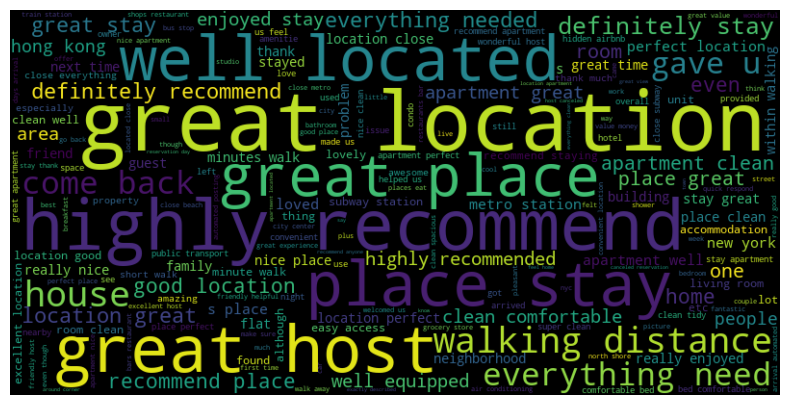

In [145]:
aggregated_reviews = df.groupby('propertyID')['cleaned_comment'].apply(lambda x: ' '.join(x)).str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400).generate(aggregated_reviews)
wordcloud.to_file("aggregate_wordcloud.png")
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [146]:
from textblob import TextBlob
import pandas as pd

# Assuming 'cleaned_comments' is a column in your DataFrame 'df' containing preprocessed text data

# Calculate sentiment polarity for each comment
df['sentiment'] = df['cleaned_comment'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Aggregate sentiment data by 'propertyID' and calculate mean, count, and standard deviation
sentiment_summary = df.groupby('propertyID')['sentiment'].agg(['mean', 'count', 'std'])

# Calculate overall mean and standard deviation for sentiment to define thresholds
mean_sentiment = df['sentiment'].mean()
std_sentiment = df['sentiment'].std()

# Define thresholds for interesting scores
high_threshold = mean_sentiment + std_sentiment
low_threshold = mean_sentiment - std_sentiment

# Function to flag interesting sentiment scores
def flag_interesting_scores(row):
    if row['mean'] >= high_threshold:
        return 'High Interest'
    elif row['mean'] <= low_threshold:
        return 'Low Interest'
    elif row['std'] > std_sentiment:
        return 'High Variability'
    return 'Normal'

# Apply the flagging function to the sentiment summary
sentiment_summary['Interest_Flag'] = sentiment_summary.apply(flag_interesting_scores, axis=1)

print(sentiment_summary)
print("Sentiment Polarity:", mean_sentiment)


                 mean  count       std Interest_Flag
propertyID                                          
10006546     0.415315     51  0.187050        Normal
1001265      0.319150     96  0.190856        Normal
10021707     0.412500      1       NaN        Normal
1003530      0.387847     70  0.152823        Normal
10038496     0.441647     70  0.187785        Normal
...               ...    ...       ...           ...
Thanks       0.600000      1       NaN        Normal
The          0.296875      3  0.089747        Normal
There        0.225000      1       NaN        Normal
Undoubtedly  0.000000      1       NaN  Low Interest
We           0.212121      1       NaN        Normal

[3408 rows x 4 columns]
Sentiment Polarity: 0.4046739018664855


<Figure size 1200x600 with 0 Axes>

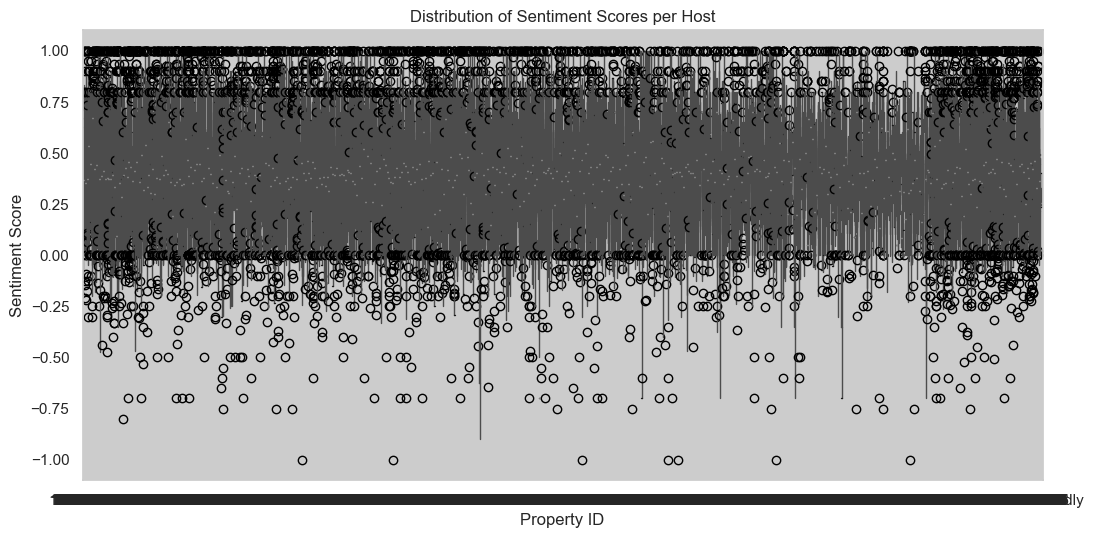

In [147]:
plt.figure(figsize=(12, 6))
df.boxplot(column='sentiment', by='propertyID', figsize=(12, 6))
plt.xlabel('Property ID')
plt.ylabel('Sentiment Score')
plt.title('Distribution of Sentiment Scores per Host')
plt.suptitle('')  # Suppress the default title to clean up the plot
TITLE_TEXT = "DBScan Cluster - French"
PATH = 'DistrSentimentScores.png'

#add_slide_with_title_and_image(prs, TITLE_TEXT, PATH)
plt.show()
plt.savefig(PATH, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline

In [148]:
# Load the CSV file and assign column names
import pandas as pd
data = []
with open('french_comments_output_nlp.txt', 'r') as file:
    for line in file:
        parts = line.strip().split(' ', 2)  # Split only on the first two spaces
        if len(parts) == 3:  # Ensure no lines with missing data
            data.append(parts)
df_french_comments = pd.DataFrame(data, columns=['propertyID', 'reviewID', 'comment'])

df_french_comments.describe()

,propertyID,reviewID,comment
count,9609,9609,9609
unique,1710,9609,9569
top,127208,73191268:,Excellent location
freq,93,1,9


In [149]:
import pandas as pd
import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk

# Download necessary NLTK resources
nltk.download('stopwords')

# Load French stopwords
french_stopwords = stopwords.words('french')

# Initialize a French Spacy model
nlp = spacy.load('fr_core_news_sm')

# Sample data creation (ensure df_french_comments is defined or loaded)
#data = {'comment': ['Ceci est un texte 123.', 'Bonjour le monde!!', None, 'Plus de texte.']}
#df_french_comments = pd.DataFrame(data)

# Function to clean text
def clean_text(text):
    if pd.isnull(text):
        return ""  # Return empty string if text is NaN
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in french_stopwords])
    return text

# Applying the cleaning function
df_french_comments['cleaned_comments'] = df_french_comments['comment'].apply(clean_text)

# Lemmatization with Spacy
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

df_french_comments['cleaned_comments'] = df_french_comments['cleaned_comments'].apply(lemmatize_text)

# Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_french_comments['cleaned_comments'])
print(X)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sanjayv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  (0, 7986)	0.09215968751040521
  (0, 2445)	0.22142826973117752
  (0, 12342)	0.22003793804541671
  (0, 6253)	0.21742998537463232
  (0, 11041)	0.13298067670154404
  (0, 9640)	0.0930147541166186
  (0, 10202)	0.1384820641082714
  (0, 6128)	0.18144318408252097
  (0, 12319)	0.1402344641228402
  (0, 9760)	0.1317442582895526
  (0, 5486)	0.2620663501386219
  (0, 512)	0.19276915782614176
  (0, 2001)	0.11571855102451027
  (0, 87)	0.093869768074115
  (0, 2068)	0.16562469965014462
  (0, 1232)	0.11500060107344601
  (0, 3928)	0.2162032668581674
  (0, 260)	0.08057593344070162
  (0, 12182)	0.07138186541384803
  (0, 9149)	0.09104012228654301
  (0, 13549)	0.11411423460757565
  (0, 240)	0.17567473932235758
  (0, 1331)	0.05206513778040676
  (0, 12713)	0.12846437178143816
  (0, 7232)	0.2964279904193085
  :	:
  (9607, 12640)	0.34510985702034713
  (9607, 10412)	0.23139107826798946
  (9607, 7362)	0.42055011866812286
  (9607, 9640)	0.24484559782985624
  (9607, 1331)	0.13705266338665623
  (9607, 12543)	0.176983

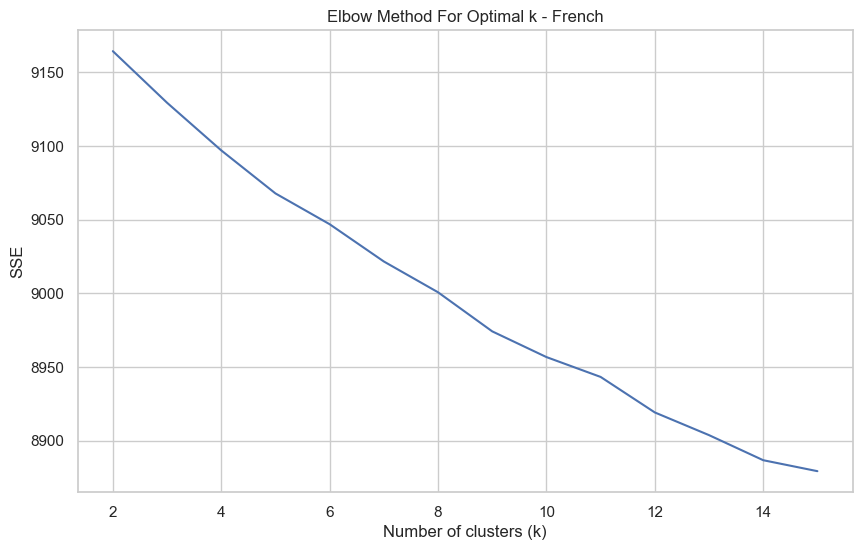

Clusters shape: (9609,)


In [150]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Assume X is the TF-IDF matrix with shape (9609, n_features)
n_samples = X.shape[0]

# Dictionary to hold the sum of squared errors for each k
sse = {}

# Loop over a range of k values, dynamically adjusted based on the number of samples
for k in range(2, min(n_samples, 15) + 1):  # Adjust the range as needed but ensure k <= n_samples
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_  # Sum of squared distances of samples to their closest cluster center

# Plotting the SSE values for each k to find the optimal k (Elbow Method)
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.title("Elbow Method For Optimal k - French")
PLOT_FILENAME_AVAILABILITY =  "ElbowMethodFrench.png"
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
plt.show()
# Define the title text and position
TITLE_TEXT = "Elbow Method For Optimal k - French"

# Path to the image you want to add
PATH = 'ElbowMethodFrench.png'

# Select the optimal number of clusters from the plot and create final clusters
optimal_k = 5  # This should be chosen based on the Elbow plot outcome
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans_final.fit_predict(X)
add_slide_with_title_and_image(prs,TITLE_TEXT,PATH)
print("Clusters shape:", clusters.shape)  # This should now output (9609,)


In [151]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt


# Initialize TruncatedSVD to reduce to 2 dimensions for visualization
svd = TruncatedSVD(n_components=2)

# Fit TruncatedSVD on the TF-IDF matrix
tfidf_svd = svd.fit_transform(X)  # No need to convert to dense array

# Optionally, visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(tfidf_svd[:, 0], tfidf_svd[:, 1], edgecolor='k', alpha=0.5)
plt.title('SVD Result - French')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.tight_layout()  # Adjust layout
PLOT_FILENAME_AVAILABILITY = 'SVDResultFrench.png'
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline

# Define the title text and position
TITLE_TEXT = "SVD Result"

# Path to the image you want to add
PATH = 'SVDResultFrench.png'

#slide.shapes.add_picture(img_path_availability, image_left, image_top, width=image_width, height=image_height)

add_slide_with_title_and_image(prs,TITLE_TEXT,PATH)
plt.show()

In [152]:
print(tfidf_svd.shape)  # Expected to print (n, 2) if tfidf_svd is an n x 2 matrix for 2D plotting
print(clusters.shape)   # Expected to print (n,) where n should match the first dimension of tfidf_svd


(9609, 2)
(9609,)


In [153]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the document clusters in SVD topic space
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tfidf_svd[:, 0], tfidf_svd[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.xlabel('Component 1: Accommodation Quality')
plt.ylabel('Component 2: Strategic Location and Communication')
plt.title('Clusters in SVD Topic Space - French')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()  # Adjust layout
PLOT_FILENAME_AVAILABILITY = 'FrenchClusters.png'
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline
print(clusters)  # Assuming 'clusters' is used as 'c' in the scatter plot
print(np.unique(clusters))  # Check the unique values

import numpy as np

clusters = np.array(clusters)  # Ensure it's a numpy array
clusters = np.nan_to_num(clusters)  # Replace NaNs with zero or another specified value
print(np.unique(clusters))  # Check again after cleaning
# Define the title text and position
TITLE_TEXT = "Clusters in SVD Topic Space - French"

# Path to the image you want to add
PATH = 'FrenchClusters.png'

#slide.shapes.add_picture(img_path_availability, image_left, image_top, width=image_width, height=image_height)

add_slide_with_title_and_image(prs,TITLE_TEXT,PATH)
plt.show()

[2 4 0 ... 0 2 4]
[0 1 2 3 4]
[0 1 2 3 4]


In [154]:
from sklearn.decomposition import LatentDirichletAllocation

# Number of topics
n_topics = 8

# Initialize and fit LDA model
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', random_state=0)
lda.fit(X)
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
convenient ben cousin relier repondre andre résident sociable marteau basic
Topic 1:
and the nice quiet to very clean is beautiful place
Topic 2:
modération laurier envers surprenant dauter lhiver jet multiple dêtre vif
Topic 3:
unique experience barbara olivier jus copain andrer communicatif tony ler
Topic 4:
location hidden by website excellent airbnb host vanessa appartment ca
Topic 5:
jusqual oscar lage tenter daffaire kip fair sylvie déj chri
Topic 6:
jorge marina retenir emplacemer équipe hong kong superbement rbnb rénovation
Topic 7:
très bien avoir situer appartemer tout bon séjour propre lappartement


In [155]:
from sklearn.decomposition import LatentDirichletAllocation

# Number of topics
n_topics = 7  # This is an example; replace with the number of clusters you determined

# Initialize and fit LDA model
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', random_state=0)
lda.fit(X)
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
location and excellent the nice quiet to very clean place
Topic 1:
convenient ca lage lagitation spot saf humidité nhésitez fantastic colocatair
Topic 2:
experience envers flexibiliter dêtre vif plaza basic déj lafontain litterie
Topic 3:
très bien avoir situer appartemer tout bon séjour propre lappartement
Topic 4:
hidden website by localiser airbnb olivier metre daccès acceuiller guid
Topic 5:
jusqual rafael essentiel repondre relation ensemble dessou staten star etant
Topic 6:
sale modération steven soucieux nuisance sonore mise compréhensif party marina


In [156]:
import nltk
from nltk.corpus import stopwords
import string

# Ensure the necessary NLTK packages are downloaded
nltk.download('stopwords')
nltk.download('punkt')  # Needed for tokenization if not already downloaded


def clean_text(text):
    # Convert text to lower case
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove French stop words
    stop_words = set(stopwords.words('french'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Clean each comment individually
df_french_comments['cleaned_comment'] = df_french_comments['comment'].astype(str).apply(clean_text)

# Extract cleaned comments into a list
cleaned_comments = df_french_comments['cleaned_comment'].tolist()

# Now save the DataFrame to a CSV file
df_french_comments.to_csv('cleaned_comments_french.csv', index=False)

# Debugging print to check the cleaned comments
print("Sample of cleaned comments:")
print(cleaned_comments[:10])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sanjayv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sanjayv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Sample of cleaned comments:
['the place to be lappartement situé milieu ribeira tout peut faire pieds cest lideallappartement très bien agencé équipé passé séjour très agréable duplex beaucoup charme accueil très chaleureux ana gonçalo pris temps indiquer tout quil faire porto répondus toutes interrogations terme commodités merci', 'super appartement très bien placé cœur lanimation ribeira passé super séjour porto toutes informations données ana documents laissés bien aidé organiser séjour presque tout fait pied parking ribeira proche bien utile garer véhicule merci philippe', 'acceuil très très chaleureux gonçalo ana lors arrivée très tardive due changement dhoraire davionappartement super bien situé porto près douro fidèle photos mises sitenous adoré quartier bien animé encore merci gonçalo ana', 'appartement très cosy court séjour 7 adoré lappartement idéalement situé quartier magnifique ribeira laccueil a ete très chaleureux trompé dadresse car gps confondus rues ana a su retrouver

In [157]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join the list of cleaned comments into a single string
all_comments_text = " ".join(cleaned_comments)  # This is the critical change

# Create and display a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()  # Adjust layout
PLOT_FILENAME_AVAILABILITY = 'FrenchWordCloud.png'
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline

# Define the title text and position
TITLE_TEXT = "Word Cloud"

# Path to the image you want to add
PATH = 'FrenchWordCloud.png'

# Add the word cloud image to the slide
add_slide_with_title_and_image(prs, TITLE_TEXT, PATH)
plt.show()

In [158]:
from sklearn.decomposition import LatentDirichletAllocation

# Number of topics
n_topics = 3  # This is an example; replace with the number of clusters you determined

# Initialize and fit LDA model
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', random_state=0)
lda.fit(X)
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
end week imbattable situ ben olivier appartment décor rbnb oscar
Topic 1:
location and excellent the nice quiet to clean place very
Topic 2:
très bien avoir situer appartemer tout bon séjour propre lappartement


Total number of comments: 9609
Average length of comments (in words): 28.04
Minimum length of comments (in words): 1
Maximum length of comments (in words): 383


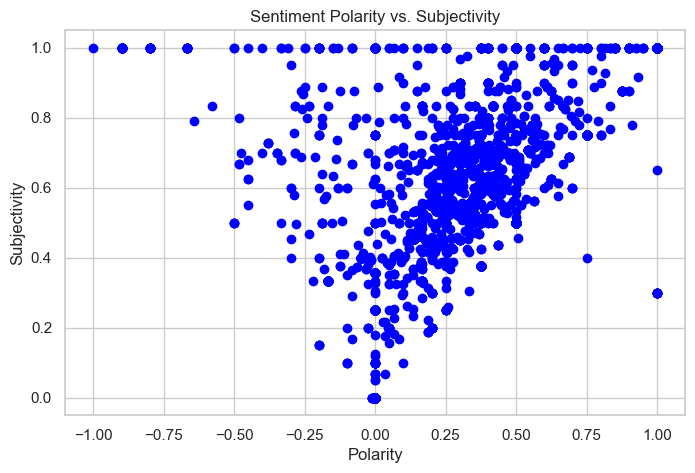

In [159]:
from textblob import TextBlob
text = cleaned_comments
polarity = []
subjectivity = []

print(f"Total number of comments: {len(cleaned_comments)}")
comment_lengths = [len(comment.split()) for comment in cleaned_comments]
print(f"Average length of comments (in words): {sum(comment_lengths) / len(comment_lengths):.2f}")
print(f"Minimum length of comments (in words): {min(comment_lengths)}")
print(f"Maximum length of comments (in words): {max(comment_lengths)}")

for text in cleaned_comments:
    blob = TextBlob(text)
    polarity.append(blob.sentiment.polarity)
    subjectivity.append(blob.sentiment.subjectivity)
plt.figure(figsize=(8, 5))
plt.scatter(polarity, subjectivity, color='blue')  # Scatter plot
plt.title('Sentiment Polarity vs. Subjectivity')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.grid(True)
PLOT_FILENAME_POLARITY = "PolarityvsSubjectivity.png"
plt.savefig(PLOT_FILENAME_POLARITY, bbox_inches='tight')  # Save the plot
TITLE_TEXT = "Sentiment Polarity vs. Subjectivity"
PATH = 'PolarityvsSubjectivity.png'
add_slide_with_title_and_image(prs, TITLE_TEXT, PATH)

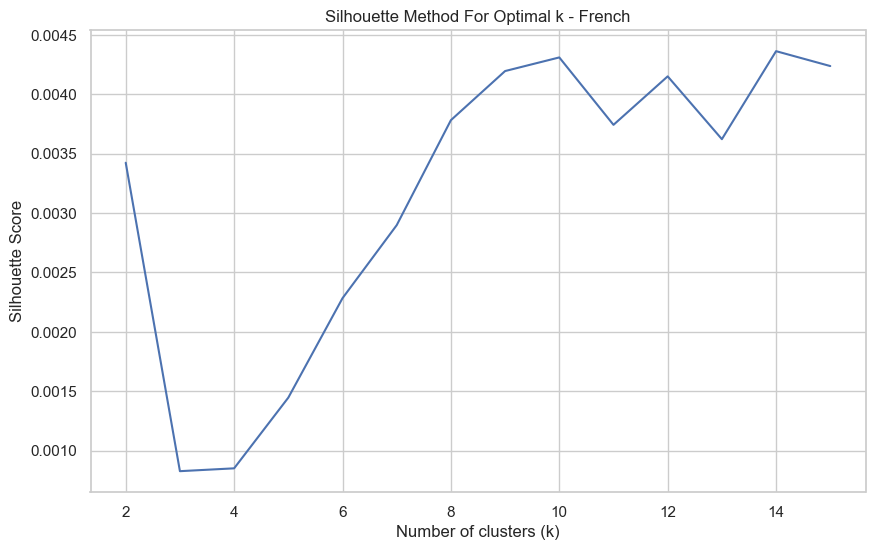

Clusters shape: (9609,)


In [160]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Assume X is the TF-IDF matrix with shape (9609, n_features)
n_samples = X.shape[0]
silhouette_scores = {}

# Loop over a range of k values
for k in range(2, min(n_samples, 15) + 1):  # k must be at least 2 to compute silhouette score
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores[k] = silhouette_avg

# Plotting the silhouette scores for each k
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()))
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method For Optimal k - French")
PLOT_FILENAME_AVAILABILITY = "SilhouetteMethodFrench.png"
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
plt.show()

# Choose the optimal number of clusters from the silhouette plot
optimal_k = max(silhouette_scores, key=silhouette_scores.get)  # Automatically find the k with the highest silhouette score
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans_final.fit_predict(X)
print("Clusters shape:", clusters.shape)  # Output should be (9609,)
TITLE_TEXT = "Silhouette Method For Optimal k - French"
PATH = 'SilhouetteMethodFrench.png'
add_slide_with_title_and_image(prs, TITLE_TEXT, PATH)

Total number of points: 9609
Estimated number of clusters: 8
Estimated number of noise points: 9544
Silhouette Coefficient: -0.053


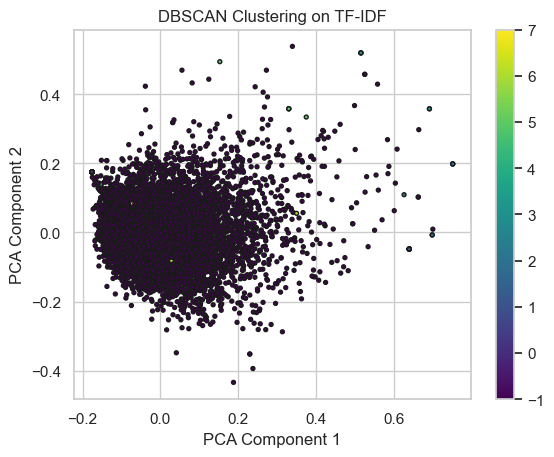

In [161]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

db = DBSCAN(eps=0.5, min_samples=5).fit(X)
labels = db.labels_

# Number of clusters and noise points
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
total_points = X.shape[0]
print("Total number of points: %d" % total_points)
print("Estimated number of clusters: %d" % n_clusters)
print("Estimated number of noise points: %d" % n_noise)
# Evaluate your model
if n_clusters > 1:
    silhouette = metrics.silhouette_score(X, labels)
    print("Silhouette Coefficient: %0.3f" % silhouette)
else:
    print("Silhouette score is not meaningful with only one cluster.")

from sklearn.decomposition import PCA

# Reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X.toarray())

# Plot
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', marker='o', s=8, edgecolor='k')
plt.title("DBSCAN Clustering on TF-IDF")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
PLOT_FILENAME_AVAILABILITY = "DBSCANClusteringonTF-IDF.png"
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
TITLE_TEXT = "DBScan Cluster - French"
PATH = 'DBSCANClusteringonTF-IDF.png'
add_slide_with_title_and_image(prs, TITLE_TEXT, PATH)
plt.show()

In [162]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# Assuming X is your data matrix in sparse format
scaler = StandardScaler(with_mean=False)  # Set with_mean=False to avoid converting sparse matrix to dense
X_scaled = scaler.fit_transform(X)  # Scaling the features

best_silhouette = -1
best_eps = 0.3
best_min_samples = 5

for eps in np.arange(0.1, 1.0, 0.1):
    for min_samples in range(2, 10):
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
        labels = db.labels_
        # Number of clusters in labels, ignoring noise if present
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            silhouette = metrics.silhouette_score(X_scaled, labels)
            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_eps = eps
                best_min_samples = min_samples
                best_n_noise = list(labels).count(-1)

print("Best eps:", best_eps)
print("Best min_samples:", best_min_samples)
print("Best Silhouette Score:", best_silhouette)



Best eps: 0.1
Best min_samples: 2
Best Silhouette Score: -0.370060362910766


In [163]:
import hdbscan

# Create an HDBSCAN instance
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)

# Fit the model
cluster_labels = clusterer.fit_predict(X)

# If you want to visualize or examine the results
print("Cluster labels:", cluster_labels)

features = vectorizer.get_feature_names_out()
for i in range(max(cluster_labels)+1):
    words = X[cluster_labels == i].sum(axis=0)
    words_freq = [(word, words[0, idx]) for word, idx in zip(features, words.nonzero()[1])]
    print('Cluster {}:'.format(i), sorted(words_freq, key=lambda x: x[1], reverse=True)[:10])


Cluster labels: [-1 -1 -1 ... -1 -1 -1]
Cluster 0: [('aboient', 3.015897815197026), ('acces', 1.3151716924274854), ('absent', 1.2866194213039102), ('abdou', 0.6583572055194795), ('accomplir', 0.6149708709721446), ('accessoire', 0.5071007846220443), ('abstenezvou', 0.46520628448973655), ('abimé', 0.43084802944023903), ('abel', 0.41715038466402404), ('accepter', 0.4147324964111585)]
Cluster 1: [('bey', 10.615362911834312), ('acceuillit', 5.720637059160134), ('biensur', 4.399380470857875), ('appartementmerci', 4.065903541224652), ('apparemer', 3.2381384893584793), ('boitier', 2.5434803690373706), ('blankets', 2.5345866650890327), ('appartementsi', 2.4915444098773514), ('boisson', 1.9476082871296005), ('attentioné', 1.9308033886538747)]
Cluster 2: [('accompagnemer', 3.430070248983823), ('ac', 1.193455801560292), ('aaron', 0.5436577443829406), ('accueil', 0.5331491946035485), ('abrigado', 0.4404515437290504), ('abri', 0.42289213251372726), ('abl', 0.41520580648456884), ('absence', 0.3945541

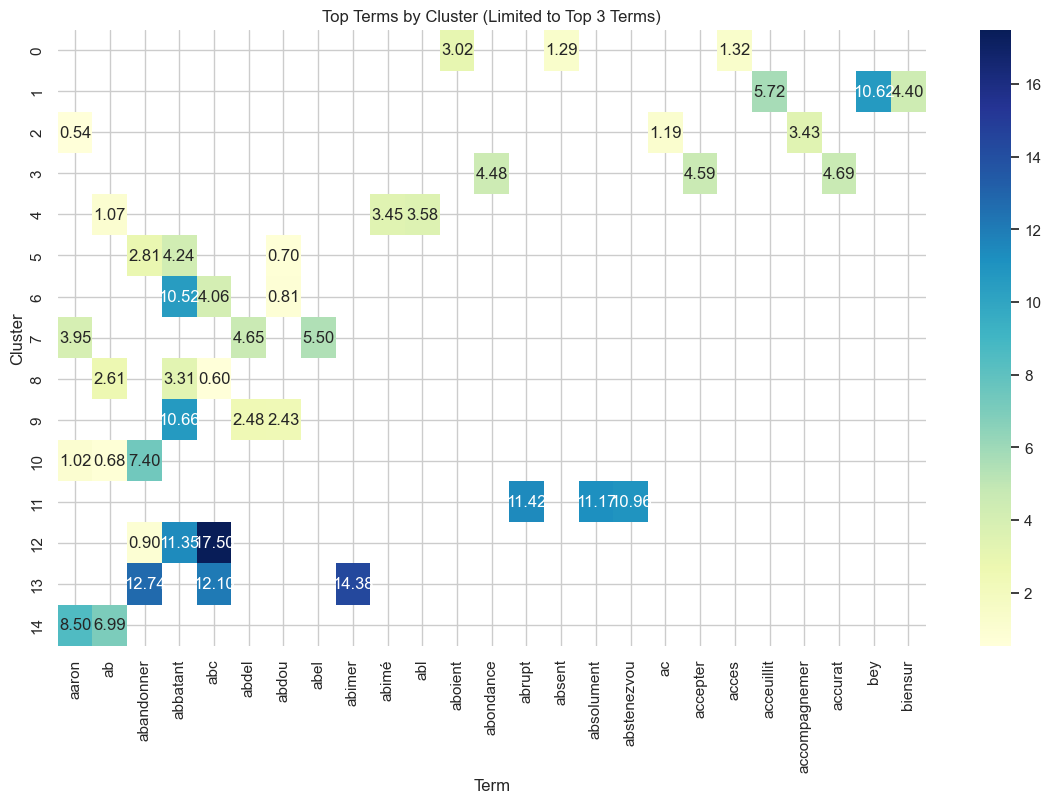

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns
clusters = {
    0: [('aboient', 3.015897815197026), ('acces', 1.3151716924274854), ('absent', 1.2866194213039102), ('abdou', 0.6583572055194795), ('accomplir', 0.6149708709721446), ('accessoire', 0.5071007846220443), ('abstenezvou', 0.46520628448973655), ('abimé', 0.43084802944023903), ('abel', 0.41715038466402404), ('accepter', 0.4147324964111585)],
    1: [('bey', 10.615362911834312), ('acceuillit', 5.720637059160134), ('biensur', 4.399380470857875), ('appartementmerci', 4.065903541224652), ('apparemer', 3.2381384893584793), ('boitier', 2.5434803690373706), ('blankets', 2.5345866650890327), ('appartementsi', 2.4915444098773514), ('boisson', 1.9476082871296005), ('attentioné', 1.9308033886538747)],
    2: [('accompagnemer', 3.430070248983823), ('ac', 1.193455801560292), ('aaron', 0.5436577443829406), ('accueil', 0.5331491946035485), ('abrigado', 0.4404515437290504), ('abri', 0.42289213251372726), ('abl', 0.41520580648456884), ('absence', 0.39455415801855487), ('accro', 0.38713653333225817), ('acceptable', 0.3562031925085106)],
   3: [('accurat', 4.694434332891674), ('accepter', 4.588089481519365), ('abondance', 4.480125176147442), ('abdou', 3.7403141396234765), ('accuil', 1.3646580773186519), ('accueilplus', 1.346598490336474), ('absent', 0.9179570706723494), ('aboient', 0.8262791012801668), ('accueillisdans', 0.7927461061766456), ('accueillier', 0.7176025754430526)],
 4: [('abl', 3.579224157482871), ('abimé', 3.450083887680123), ('ab', 1.0710790411117719), ('abendessen', 0.985751614750991), ('abdou', 0.9772922148909632), ('aaron', 0.9131608871828247), ('abdul', 0.8176266538022376), ('abimer', 0.7267211389676129), ('abc', 0.5799243555956338), ('abandonner', 0.5239420190508456)],
 5: [('abbatant', 4.239153513426598), ('abandonner', 2.8120694173365783), ('abdou', 0.6953384101790241), ('ab', 0.6541445425100351), ('aaron', 0.5102780549629888), ('abdel', 0.4880566695070273), ('abc', 0.35208015838904383), ('abdul', 0.34211612703544164)],
 6: [('abbatant', 10.517106409338956), ('abc', 4.057427343192172), ('abdou', 0.8067534280985745), ('abendessen', 0.6243795335532866), ('abandonner', 0.569200088807734), ('abdul', 0.5645996087126156), ('ab', 0.5196238478063797), ('abdel', 0.4847222610458474), ('aaron', 0.48256411200126714), ('abel', 0.3423025727383048)],
 7: [('abel', 5.503370592345871), ('abdel', 4.647785220651051), ('aaron', 3.949376975225008), ('ab', 3.248533584271468), ('abendessen', 2.015993197856794), ('abdul', 1.6553078682353481), ('abdou', 1.0826494763324526), ('abandonner', 1.0758233066840055), ('abbatant', 0.5826357403617112), ('aber', 0.5734530822876214)],
 8: [('abbatant', 3.3146683379736057), ('ab', 2.609348565729041), ('abc', 0.6035233580485494), ('aaron', 0.578955658065389), ('abandonner', 0.5031742157487539), ('abdel', 0.29533080327910904)],
 9: [('abbatant', 10.663286412013933), ('abdel', 2.47609913817404), ('abdou', 2.42955907450279), ('aaron', 1.2856823878718635), ('abc', 0.5566763535724599), ('ab', 0.4968679505914269), ('abandonner', 0.39446353703284764)],
 10: [('abandonner', 7.399499590497012), ('aaron', 1.0225872413379555), ('ab', 0.6799192589228735)],
 11: [('abrupt', 11.423670307105633), ('absolument', 11.172947590417197), ('abstenezvou', 10.957535176527252), ('abdou', 5.596375402881114), ('acceptable', 2.2763175092988037), ('abl', 1.5120299056180984), ('abdel', 1.294477648640998), ('abrigada', 1.0636295328820653), ('abimer', 0.7127042437834478), ('abri', 0.6840270240912463)],
 12: [('abc', 17.49906675787092), ('abbatant', 11.348914666343335), ('abandonner', 0.9045146948853442), ('abdel', 0.5404442990675139), ('abdou', 0.5034151877775055), ('ab', 0.4077588180207658), ('aaron', 0.2783102388116768)],
 13: [('abimer', 14.380517449454963), ('abandonner', 12.737327332397067), ('abc', 12.101646743449194), ('aboard', 10.73663965809863), ('aber', 8.3713753049123), ('abbatant', 6.75332870363467), ('abel', 2.8196624059267617), ('abdel', 1.1718611511928148), ('abl', 1.1613847279874427), ('abdou', 1.036406695152831)],
 14: [('aaron', 8.495692142127158), ('ab', 6.987361091728327)]
}

# Create a DataFrame for better presentation
data = []
for cluster_id, terms in clusters.items():
    for term, score in terms:
        data.append([cluster_id, term, score])

df = pd.DataFrame(data, columns=['Cluster', 'Term', 'Score'])
top_n_terms = 3
limited_clusters = {cluster_id: terms[:top_n_terms] for cluster_id, terms in clusters.items()}

# Create a DataFrame for better presentation
data = []
for cluster_id, terms in limited_clusters.items():
    for term, score in terms:
        data.append([cluster_id, term, score])

df = pd.DataFrame(data, columns=['Cluster', 'Term', 'Score'])

# Convert the DataFrame to pivot for heatmap visualization
pivot_df = df.pivot(index="Cluster", columns="Term", values="Score")

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Top Terms by Cluster (Limited to Top 3 Terms)")
PLOT_FILENAME_AVAILABILITY = "TERMSBYCLUSTER.png"
plt.savefig(PLOT_FILENAME_AVAILABILITY, bbox_inches='tight')  # Save the plot
TITLE_TEXT = "Top Terms By Cluster - French"
PATH = 'TERMSBYCLUSTER.png'
add_slide_with_title_and_image(prs, TITLE_TEXT, PATH)
plt.show()


In [165]:
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN


def add_new_slide_with_title(prs, title):
    slide_layout = prs.slide_layouts[5]  # Choosing a blank layout
    slide = prs.slides.add_slide(slide_layout)
    title_shape = slide.shapes.title
    if title_shape:
        title_shape.text = title
    return slide

# Helper function to add bullet points with bold section titles
def add_bullet_points(slide, points):
    txBox = slide.shapes.add_textbox(Inches(1), Inches(1.5), Inches(8), Inches(6))
    tf = txBox.text_frame

    for point in points:
        if ':' in point:
            title, content = point.split(':', 1)
            p = tf.add_paragraph()
            p.text = title + ":"
            p.font.bold = True
            p.space_after = Inches(0.1)
            p.alignment = PP_ALIGN.LEFT
            
            # Add the rest of the text
            p = tf.add_paragraph()
            p.text = content.strip()
            p.space_after = Inches(0.1)
            p.alignment = PP_ALIGN.LEFT
        else:
            p = tf.add_paragraph()
            p.text = point
            p.space_after = Inches(0.1)
            p.alignment = PP_ALIGN.LEFT

# Grouping the suggestions
overview_points = [
    "This presentation provides business and host suggestions based on Airbnb data analysis.",
    "The suggestions aim to enhance customer satisfaction, optimize pricing, and improve overall listing performance."
]

airbnb_suggestions_part1 = [
    "Promote High Availability Listings: Emphasize listings with high availability (365 days) in marketing campaigns, especially during off-peak seasons, to attract long-term bookings.",
    "Pricing Strategy: Develop dynamic pricing algorithms that consider factors like the number of beds, property type, location, and amenities to optimize revenue. Highlight properties with unique offerings like houseboats and heritage hotels in premium segments.",
    "Cluster Analysis for Market Insights: Utilize clustering analysis to understand distinct customer segments and tailor marketing efforts accordingly. For example, targeting customers interested in properties with high accommodation quality or strategic location and communication.",
    "Enhance Review Features: Improve the review system by emphasizing consistent positive aspects like cleanliness, accuracy, and value. Provide tools for hosts to manage and enhance these features."
]

airbnb_suggestions_part2 = [
    "Seasonal Promotions: Launch targeted promotions during low occupancy periods (February and November) to boost bookings. Offer discounts or special packages to attract guests during these months.",
    "Host Responsiveness: Encourage hosts to respond within an hour by offering incentives or recognition for quick responses. This can improve customer satisfaction and increase booking rates.",
    "Insights from Sentiment Analysis: Use sentiment analysis to identify areas for improvement and common concerns among guests. Share these insights with hosts to help them enhance the guest experience.",
    "Enhance Listing Descriptions: Provide guidelines for hosts to highlight frequently mentioned positive terms like 'clean', 'well-located', and 'comfortable' in their listings. This can improve the attractiveness of the listings."
]

host_suggestions_part1 = [
    "Maximize Availability: Aim to increase the availability of properties throughout the year to attract more bookings. Consider flexible booking policies to accommodate long-term stays.",
    "Optimize Pricing: Use data-driven insights to set competitive prices, especially for properties with unique features or high demand during certain seasons. Regularly review and adjust prices based on market trends.",
    "Highlight Unique Features: Emphasize unique aspects of the property, such as a heritage hotel or a houseboat, in the listing to attract higher-paying guests. Showcase amenities that differentiate the property from others.",
    "Focus on Cleanliness and Accuracy: Ensure the property is clean and accurately described in the listing. Positive reviews in these areas can lead to higher overall ratings and more bookings."
]

host_suggestions_part2 = [
    "Provide Essential Amenities: Equip the property with essential amenities like WiFi, kitchen essentials, and TV, as these are highly valued by guests. Consider adding amenities that drive higher booking frequencies, such as a mini fridge or outdoor seating.",
    "Improve Responsiveness: Aim to respond to inquiries within an hour to enhance guest satisfaction and increase the likelihood of bookings. Utilize Airbnb’s tools to manage and automate responses where possible.",
    "Seasonal Adjustments: Prepare for seasonal fluctuations by offering special rates or packages during low occupancy months. Highlight seasonal attractions or activities near the property to attract guests.",
    "Leverage Guest Feedback: Actively seek and respond to guest feedback to continuously improve the property and guest experience. Address common concerns identified through sentiment analysis to enhance reviews."
]

# Slide 1: Overview
slide = add_new_slide_with_title(prs, "Overview of Business and Host Suggestions")
add_bullet_points(slide, overview_points)

# Slide 2: Airbnb Suggestions Part 1
slide = add_new_slide_with_title(prs, "Airbnb Suggestions (1/2)")
add_bullet_points(slide, airbnb_suggestions_part1)

# Slide 3: Airbnb Suggestions Part 2
slide = add_new_slide_with_title(prs, "Airbnb Suggestions (2/2)")
add_bullet_points(slide, airbnb_suggestions_part2)

# Slide 4: Host Suggestions Part 1
slide = add_new_slide_with_title(prs, "Host Suggestions (1/2)")
add_bullet_points(slide, host_suggestions_part1)

# Slide 5: Host Suggestions Part 2
slide = add_new_slide_with_title(prs, "Host Suggestions (2/2)")
add_bullet_points(slide, host_suggestions_part2)


In [166]:
save_ppt(prs)

Presentation saved successfully.
